# First Model Experiments

In this notebook I have made the first model experiments to have a baseline to start from. The objectives of this notebook are: 
* Deriving a data preparation procedure
* Define the models and metrics to use
* Track experiments and set up a model registry with MLFlow
* Saving a first draft of the models

In [1]:
import pandas as pd
import numpy as np

import matplotlib as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score, f1_score

import xgboost as xgb

import optuna

import mlflow
from mlflow.tracking import MlflowClient

import pickle

In [2]:
RANDOM_STATE = 2024

MLFLOW_TRACKING_URI = "sqlite:///bank_churn.db"

In [3]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bank_churn_prediction")

2024/07/20 16:37:11 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/07/20 16:37:11 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/mlruns/1', creation_time=1721493434662, experiment_id='1', last_update_time=1721493434662, lifecycle_stage='active', name='bank_churn_prediction', tags={}>

To launch mlflow, execute the following command in your terminal: 

mlflow server --backend-store-uri sqlite:///bank_churn.db --default-artifact-root ./artifacts

### Data Preparation

In [4]:
data = pd.read_parquet('../data/customer_churn_records.parquet')

In [5]:
data.drop(['RowNumber','CustomerId','Surname'], 
          axis = 1, inplace = True)

categorical_variables = ['Geography', 'Gender', 'Card Type']
target = 'Exited'
isf_variables = [target, 'Age','CreditScore','NumOfProducts'] 

data[categorical_variables] = data[categorical_variables].astype('category')

In [6]:
test_size = 0.2

train_data, val_data = train_test_split(data, test_size=test_size, random_state=RANDOM_STATE)


The following cell has only been used once to save data and it's not necessary to run it again. 


In [8]:
# train_data.to_parquet('../data/customer_churn_training_data.parquet', engine="pyarrow")
# val_data.to_parquet('../data/customer_churn_validation_data.parquet', engine="pyarrow")

### Model Experiments - Anomaly Detection

In [11]:
def objective_isf(trial):
    
    with mlflow.start_run(run_name = "anomaly_detection"):
        mlflow.set_tag("Project", "bank_churn_prediction")
        mlflow.set_tag("Developer", "Francesca")
        mlflow.set_tag("Model", "isolation_forest")
    
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 500, 10),
            'contamination': trial.suggest_discrete_uniform('contamination', 0.05, 0.5, 0.05),
            'max_features': trial.suggest_int('max_features', 1, 4),
            'bootstrap': True,
            'warm_start': True,
            'random_state': RANDOM_STATE
        }
        
        mlflow.log_params(params)

        isf = IsolationForest(**params)
        isf.fit(train_data[isf_variables])
        
        anomalies = isf.predict(val_data[isf_variables])
        
        pct_returning, pct_inliers = compute_isf_metrics(val_data[isf_variables], anomalies)
        score = (1 - pct_returning)*(1 - pct_inliers)
        
        mlflow.log_metric("pct_returning", pct_returning)
        mlflow.log_metric("pct_inliers", pct_inliers)
        mlflow.log_metric("score", score)
        
        mlflow.sklearn.log_model(isf, artifact_path="mlflow_models")
    
    return score

def compute_isf_metrics(val_data, anomalies):
    
    val_data['Anomalies'] = anomalies
    
    pct_returning = len(val_data[(val_data['Anomalies']==1) & (val_data[target]==0)])/len(val_data[val_data['Anomalies']==1])
    pct_inliers = len(val_data[val_data['Anomalies']==1])/len(anomalies)
    
    return pct_returning, pct_inliers

In [12]:
study_isf = optuna.create_study(direction='minimize') 
study_isf.optimize(objective_isf, n_trials=50) 

[I 2024-07-20 16:38:45,256] A new study created in memory with name: no-name-5755461d-930b-437e-981f-8bd4b22bdefb
/tmp/ipykernel_9365/1553850151.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 500, 10),
/tmp/ipykernel_9365/1553850151.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'contamination': trial.suggest_discrete_uniform('contamination', 0.05, 0.5, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/tmp/ipykernel_9365/1553850151.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [13]:
isf=IsolationForest(**study_isf.best_params)

isf.fit(train_data[isf_variables])

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.45, max_features=2, n_estimators=470)

In [9]:
# With these parameters found in a couple of trials I obtained the best score
# n_estimators=150, 
# max_samples='auto', 
# contamination=0.45,
# max_features=1.0,
# bootstrap = True, 
# warm_start = True,
# random_state=RANDOM_STATE

In [14]:
anomalies = isf.predict(val_data[isf_variables])

data_anom = val_data.copy()
data_anom['Anomalies'] = anomalies
data_anom

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned,Anomalies
8276,580,Spain,Male,32,9,142188.20,2,0,1,128028.60,0,0,3,DIAMOND,332,1
9288,635,Germany,Female,36,9,81231.85,2,1,0,196731.08,0,0,3,GOLD,839,1
530,519,Spain,Female,57,2,119035.35,2,1,1,29871.79,0,0,3,SILVER,689,-1
8127,651,Germany,Male,35,8,110067.71,1,1,0,127678.95,1,1,2,GOLD,689,-1
9903,606,France,Female,36,10,0.00,2,0,1,155641.46,0,0,2,SILVER,813,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,666,France,Male,46,5,123873.19,1,1,1,177844.06,0,0,2,PLATINUM,742,1
2688,558,Germany,Male,32,4,108235.91,1,1,1,143783.28,0,0,4,DIAMOND,801,1
2656,779,Spain,Female,34,5,0.00,2,0,1,111676.63,0,0,1,SILVER,945,1
3578,704,Germany,Female,39,1,124640.51,1,1,0,116511.12,1,1,5,DIAMOND,565,-1


<AxesSubplot:xlabel='Exited', ylabel='Count'>

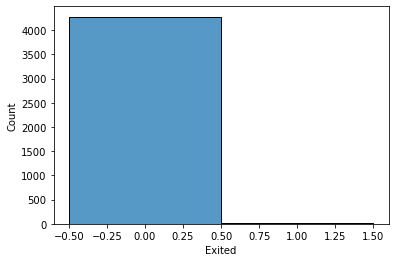

In [15]:
sns.histplot(data_anom[data_anom['Anomalies']==1][target], discrete=True)

<AxesSubplot:xlabel='Exited', ylabel='Count'>

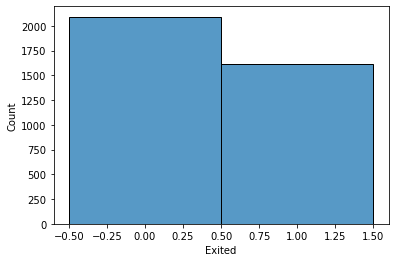

In [16]:
sns.histplot(data_anom[data_anom['Anomalies']==-1][target], discrete=True)

After applying anomaly detection, the dataset is not unbalanced anymore. Furthermore, we can already filter more than 40% of customers by setting a big chunk of returning customers on the side. 

<AxesSubplot:xlabel='Age', ylabel='Count'>

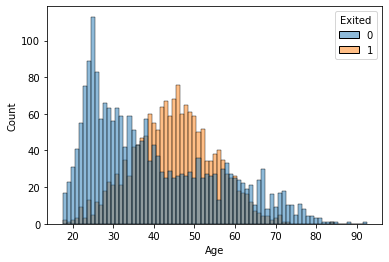

In [17]:
sns.histplot(data=data_anom[data_anom['Anomalies']==-1], x='Age', hue=target, discrete=True)

<AxesSubplot:xlabel='Age', ylabel='Count'>

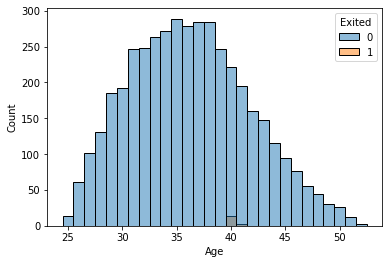

In [18]:
sns.histplot(data=data_anom[data_anom['Anomalies']==1], x='Age', hue=target, discrete=True)

<AxesSubplot:xlabel='NumOfProducts', ylabel='Count'>

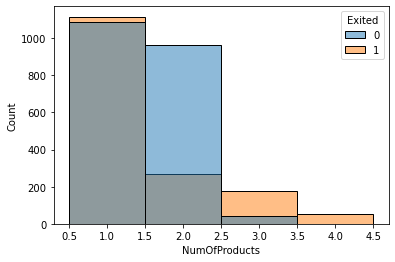

In [20]:
sns.histplot(data=data_anom[data_anom['Anomalies']==-1], x='NumOfProducts', hue=target, discrete=True)

<AxesSubplot:xlabel='NumOfProducts', ylabel='Count'>

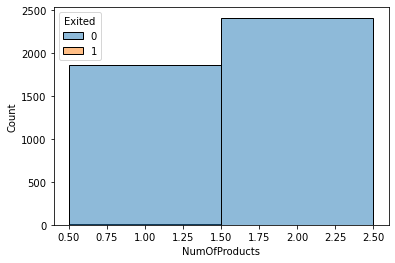

In [21]:
sns.histplot(data=data_anom[data_anom['Anomalies']==1], x='NumOfProducts', hue=target, discrete=True)

<AxesSubplot:xlabel='CreditScore', ylabel='Count'>

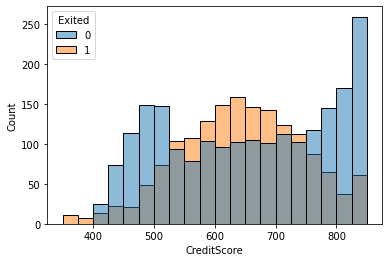

In [22]:
sns.histplot(data=data_anom[data_anom['Anomalies']==-1], x='CreditScore', hue=target)

<AxesSubplot:xlabel='CreditScore', ylabel='Count'>

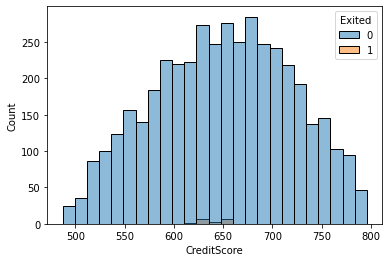

In [23]:
sns.histplot(data=data_anom[data_anom['Anomalies']==1], x='CreditScore', hue=target)

We can see how Isolation Forests also level out the most irregular distributions.

In [25]:
with open('../models/isolation_forest.bin', 'wb') as f_out:
    pickle.dump(isf, f_out)

In [26]:
mlflow.log_artifact("../models/isolation_forest.bin", artifact_path="isolation_forest")

In [28]:
client = MlflowClient("http://127.0.0.1:5000")
client.search_registered_models()

[]

In [29]:
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/mlruns/1', creation_time=1721493434662, experiment_id='1', last_update_time=1721493434662, lifecycle_stage='active', name='bank_churn_prediction', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/mlruns/0', creation_time=1721493434625, experiment_id='0', last_update_time=1721493434625, lifecycle_stage='active', name='Default', tags={}>]

In [40]:
run_id = 'a81512e7ee184ef98b923cb89a712120' #Found on MLFlow UI

mlflow.register_model(
    model_uri=f"runs:/{run_id}/isolation_forest",
    name='isolation_forest'
)

Successfully registered model 'isolation_forest'.
Created version '1' of model 'isolation_forest'.


<ModelVersion: aliases=[], creation_timestamp=1721494750604, current_stage='None', description=None, last_updated_timestamp=1721494750604, name='isolation_forest', run_id='a81512e7ee184ef98b923cb89a712120', run_link=None, source='/workspaces/mlops-zoomcamp/final_project/mlruns/1/a81512e7ee184ef98b923cb89a712120/artifacts/isolation_forest', status='READY', status_message=None, tags={}, user_id=None, version=1>

### Model Experiments - XGBoost

In [43]:
X_train = train_data.drop(target, axis=1)
y_train = train_data[target]

X_val = val_data.drop(target, axis=1)
y_val = val_data[target]

In [44]:
train_matrix = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
val_matrix = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

In [45]:
def objective_xgb(trial):
    
    with mlflow.start_run(run_name = "xgboost_classifier"):
        mlflow.set_tag("Project", "bank_churn_prediction")
        mlflow.set_tag("Developer", "Francesca")
        mlflow.set_tag("Model", "xgboost")
        
        params = {
            'objective': 'binary:logistic',
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
            'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
            'max_depth': trial.suggest_int('max_depth', 2, 100),
            'seed': RANDOM_STATE
        }
        
        mlflow.log_params(params)

        classifier = xgb.train(
                params = params,
                dtrain = train_matrix,
                num_boost_round = 1000,
                evals=[(val_matrix, 'validation')],
                early_stopping_rounds = 50
            )

        y_pred = np.rint(classifier.predict(val_matrix))

        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        mlflow.xgboost.log_model(classifier, artifact_path="mlflow_models")
    
    return recall 

In [46]:
study_xgb = optuna.create_study(direction='maximize') 
study_xgb.optimize(objective_xgb, n_trials=50) 

[I 2024-07-20 16:59:58,245] A new study created in memory with name: no-name-f718f001-92e9-4284-9d3c-6d25364184e0
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_9365/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),


[0]	validation-logloss:0.11427
[1]	validation-logloss:0.05351
[2]	validation-logloss:0.02931
[3]	validation-logloss:0.02056
[4]	validation-logloss:0.01513


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:59:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation-logloss:0.01497
[6]	validation-logloss:0.01494
[7]	validation-logloss:0.01524
[8]	validation-logloss:0.01404
[9]	validation-logloss:0.01400
[10]	validation-logloss:0.01400
[11]	validation-logloss:0.01403
[12]	validation-logloss:0.01404
[13]	validation-logloss:0.01410
[14]	validation-logloss:0.01401
[15]	validation-logloss:0.01398
[16]	validation-logloss:0.01400
[17]	validation-logloss:0.01424
[18]	validation-logloss:0.01399
[19]	validation-logloss:0.01401
[20]	validation-logloss:0.01404
[21]	validation-logloss:0.01401
[22]	validation-logloss:0.01400
[23]	validation-logloss:0.01400
[24]	validation-logloss:0.01401
[25]	validation-logloss:0.01407
[26]	validation-logloss:0.01402
[27]	validation-logloss:0.01404
[28]	validation-logloss:0.01400
[29]	validation-logloss:0.01452
[30]	validation-logloss:0.01418
[31]	validation-logloss:0.01420
[32]	validation-logloss:0.01508
[33]	validation-logloss:0.01415
[34]	validation-logloss:0.01416
[35]	validation-logloss:0.01435
[36]	validati

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:59:58] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:00:03,186] Trial 0 finished with value: 0.998158379373849 and parameters: {'n_estimators': 410, 'learning_rate': 0.8230318431408498, 'subsample': 0.1, 'max_depth': 54}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=Tr

[0]	validation-logloss:0.36113
[1]	validation-logloss:0.27909
[2]	validation-logloss:0.22184
[3]	validation-logloss:0.17928
[4]	validation-logloss:0.14631
[5]	validation-logloss:0.12049
[6]	validation-logloss:0.09992
[7]	validation-logloss:0.08341
[8]	validation-logloss:0.07008
[9]	validation-logloss:0.05905
[10]	validation-logloss:0.05039
[11]	validation-logloss:0.04314
[12]	validation-logloss:0.03707
[13]	validation-logloss:0.03206
[14]	validation-logloss:0.02782
[15]	validation-logloss:0.02480
[16]	validation-logloss:0.02213
[17]	validation-logloss:0.02019
[18]	validation-logloss:0.01823
[19]	validation-logloss:0.01663
[20]	validation-logloss:0.01549
[21]	validation-logloss:0.01442
[22]	validation-logloss:0.01342
[23]	validation-logloss:0.01273
[24]	validation-logloss:0.01228
[25]	validation-logloss:0.01184
[26]	validation-logloss:0.01139
[27]	validation-logloss:0.01122
[28]	validation-logloss:0.01105
[29]	validation-logloss:0.01073
[30]	validation-logloss:0.01058
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[34]	validation-logloss:0.00999
[35]	validation-logloss:0.00997
[36]	validation-logloss:0.00984
[37]	validation-logloss:0.00977
[38]	validation-logloss:0.00964
[39]	validation-logloss:0.00954
[40]	validation-logloss:0.00945
[41]	validation-logloss:0.00939
[42]	validation-logloss:0.00933
[43]	validation-logloss:0.00933
[44]	validation-logloss:0.00932
[45]	validation-logloss:0.00940
[46]	validation-logloss:0.00933
[47]	validation-logloss:0.00930
[48]	validation-logloss:0.00938
[49]	validation-logloss:0.00932
[50]	validation-logloss:0.00933
[51]	validation-logloss:0.00933
[52]	validation-logloss:0.00936
[53]	validation-logloss:0.00936
[54]	validation-logloss:0.00936
[55]	validation-logloss:0.00932
[56]	validation-logloss:0.00933
[57]	validation-logloss:0.00931
[58]	validation-logloss:0.00931
[59]	validation-logloss:0.00925
[60]	validation-logloss:0.00925
[61]	validation-logloss:0.00923
[62]	validation-logloss:0.00924
[63]	validation-logloss:0.00922
[64]	validation-logloss:0.00922
[65]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:04] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:00:07,709] Trial 1 finished with value: 0.998158379373849 and parameters: {'n_estimators': 630, 'learning_rate': 0.18331923992407834, 'subsample': 0.6000000000000001, 'max_depth': 17}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.49838
[1]	validation-logloss:0.48897
[2]	validation-logloss:0.47990
[3]	validation-logloss:0.47115
[4]	validation-logloss:0.46269
[5]	validation-logloss:0.45454
[6]	validation-logloss:0.44661
[7]	validation-logloss:0.43892


/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_9365/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:07] WARNING: /workspace/src/learner.cc:

[8]	validation-logloss:0.43145
[9]	validation-logloss:0.42417
[10]	validation-logloss:0.41716
[11]	validation-logloss:0.41030
[12]	validation-logloss:0.40359
[13]	validation-logloss:0.39708
[14]	validation-logloss:0.39070
[15]	validation-logloss:0.38455
[16]	validation-logloss:0.37854
[17]	validation-logloss:0.37269
[18]	validation-logloss:0.36694
[19]	validation-logloss:0.36131
[20]	validation-logloss:0.35584
[21]	validation-logloss:0.35046
[22]	validation-logloss:0.34519
[23]	validation-logloss:0.34006
[24]	validation-logloss:0.33504
[25]	validation-logloss:0.33012
[26]	validation-logloss:0.32531
[27]	validation-logloss:0.32062
[28]	validation-logloss:0.31604
[29]	validation-logloss:0.31151
[30]	validation-logloss:0.30709
[31]	validation-logloss:0.30276
[32]	validation-logloss:0.29849
[33]	validation-logloss:0.29432
[34]	validation-logloss:0.29025
[35]	validation-logloss:0.28626
[36]	validation-logloss:0.28230
[37]	validation-logloss:0.27844
[38]	validation-logloss:0.27463
[39]	valid

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:00:15,720] Trial 2 finished with value: 0.998158379373849 and parameters: {'n_estimators': 770, 'learning_rate': 0.011047329756188188, 'subsample': 0.6500000000000001, 'max_depth': 12}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50602
[1]	validation-logloss:0.50390
[2]	validation-logloss:0.50180
[3]	validation-logloss:0.49971
[4]	validation-logloss:0.49765
[5]	validation-logloss:0.49560


/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_9365/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:15] WARNING: /workspace/src/learner.cc:

[6]	validation-logloss:0.49357
[7]	validation-logloss:0.49156
[8]	validation-logloss:0.48956
[9]	validation-logloss:0.48756
[10]	validation-logloss:0.48560
[11]	validation-logloss:0.48364
[12]	validation-logloss:0.48169
[13]	validation-logloss:0.47976
[14]	validation-logloss:0.47784
[15]	validation-logloss:0.47594
[16]	validation-logloss:0.47405
[17]	validation-logloss:0.47218
[18]	validation-logloss:0.47031
[19]	validation-logloss:0.46847
[20]	validation-logloss:0.46663
[21]	validation-logloss:0.46481
[22]	validation-logloss:0.46299
[23]	validation-logloss:0.46119
[24]	validation-logloss:0.45941
[25]	validation-logloss:0.45763
[26]	validation-logloss:0.45587
[27]	validation-logloss:0.45413
[28]	validation-logloss:0.45241
[29]	validation-logloss:0.45068
[30]	validation-logloss:0.44897
[31]	validation-logloss:0.44727
[32]	validation-logloss:0.44557
[33]	validation-logloss:0.44389
[34]	validation-logloss:0.44223
[35]	validation-logloss:0.44058
[36]	validation-logloss:0.43893
[37]	validat

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:19] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:00:22,863] Trial 3 finished with value: 0.998158379373849 and parameters: {'n_estimators': 230, 'learning_rate': 0.002417040973753566, 'subsample': 0.55, 'max_depth': 53}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.48254
[1]	validation-logloss:0.45941
[2]	validation-logloss:0.43820
[3]	validation-logloss:0.41870
[4]	validation-logloss:0.40062
[5]	validation-logloss:0.38387
[6]	validation-logloss:0.36821


/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_9365/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:23] WARNING: /workspace/src/learner.cc:

[7]	validation-logloss:0.35351
[8]	validation-logloss:0.33964
[9]	validation-logloss:0.32651
[10]	validation-logloss:0.31420
[11]	validation-logloss:0.30249
[12]	validation-logloss:0.29135
[13]	validation-logloss:0.28080
[14]	validation-logloss:0.27069
[15]	validation-logloss:0.26116
[16]	validation-logloss:0.25207
[17]	validation-logloss:0.24340
[18]	validation-logloss:0.23504
[19]	validation-logloss:0.22708
[20]	validation-logloss:0.21946
[21]	validation-logloss:0.21218
[22]	validation-logloss:0.20515
[23]	validation-logloss:0.19840
[24]	validation-logloss:0.19194
[25]	validation-logloss:0.18573
[26]	validation-logloss:0.17980
[27]	validation-logloss:0.17411
[28]	validation-logloss:0.16863
[29]	validation-logloss:0.16331
[30]	validation-logloss:0.15824
[31]	validation-logloss:0.15333
[32]	validation-logloss:0.14860
[33]	validation-logloss:0.14405
[34]	validation-logloss:0.13969
[35]	validation-logloss:0.13549
[36]	validation-logloss:0.13140
[37]	validation-logloss:0.12748
[38]	valida

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:24] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:00:28,155] Trial 4 finished with value: 0.998158379373849 and parameters: {'n_estimators': 80, 'learning_rate': 0.029131729396100776, 'subsample': 0.7500000000000001, 'max_depth': 88}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

[0]	validation-logloss:0.38218
[1]	validation-logloss:0.30523
[2]	validation-logloss:0.24937
[3]	validation-logloss:0.20688
[4]	validation-logloss:0.17334
[5]	validation-logloss:0.14642
[6]	validation-logloss:0.12438
[7]	validation-logloss:0.10602
[8]	validation-logloss:0.09111
[9]	validation-logloss:0.07817
[10]	validation-logloss:0.06761
[11]	validation-logloss:0.05889
[12]	validation-logloss:0.05133
[13]	validation-logloss:0.04494
[14]	validation-logloss:0.03939
[15]	validation-logloss:0.03488
[16]	validation-logloss:0.03088
[17]	validation-logloss:0.02790
[18]	validation-logloss:0.02515
[19]	validation-logloss:0.02266
[20]	validation-logloss:0.02077
[21]	validation-logloss:0.01917
[22]	validation-logloss:0.01762
[23]	validation-logloss:0.01647
[24]	validation-logloss:0.01552
[25]	validation-logloss:0.01474
[26]	validation-logloss:0.01401
[27]	validation-logloss:0.01358
[28]	validation-logloss:0.01332
[29]	validation-logloss:0.01279
[30]	validation-logloss:0.01259
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[45]	validation-logloss:0.00975
[46]	validation-logloss:0.00968
[47]	validation-logloss:0.00968
[48]	validation-logloss:0.00971
[49]	validation-logloss:0.00969
[50]	validation-logloss:0.00966
[51]	validation-logloss:0.00970
[52]	validation-logloss:0.00972
[53]	validation-logloss:0.00972
[54]	validation-logloss:0.00962
[55]	validation-logloss:0.00963
[56]	validation-logloss:0.00966
[57]	validation-logloss:0.00966
[58]	validation-logloss:0.00962
[59]	validation-logloss:0.00959
[60]	validation-logloss:0.00959
[61]	validation-logloss:0.00962
[62]	validation-logloss:0.00962
[63]	validation-logloss:0.00962
[64]	validation-logloss:0.00962
[65]	validation-logloss:0.00962
[66]	validation-logloss:0.00962
[67]	validation-logloss:0.00961
[68]	validation-logloss:0.00961
[69]	validation-logloss:0.00960
[70]	validation-logloss:0.00961
[71]	validation-logloss:0.00969
[72]	validation-logloss:0.00968
[73]	validation-logloss:0.00967
[74]	validation-logloss:0.00967
[75]	validation-logloss:0.00968
[76]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:00:33,241] Trial 5 finished with value: 0.998158379373849 and parameters: {'n_estimators': 10, 'learning_rate': 0.15600134344676453, 'subsample': 0.4, 'max_depth': 39}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=Tr

[0]	validation-logloss:0.50714
[1]	validation-logloss:0.50611
[2]	validation-logloss:0.50509
[3]	validation-logloss:0.50408
[4]	validation-logloss:0.50308
[5]	validation-logloss:0.50208
[6]	validation-logloss:0.50108
[7]	validation-logloss:0.50008
[8]	validation-logloss:0.49910
[9]	validation-logloss:0.49810
[10]	validation-logloss:0.49711
[11]	validation-logloss:0.49614
[12]	validation-logloss:0.49515
[13]	validation-logloss:0.49418
[14]	validation-logloss:0.49321
[15]	validation-logloss:0.49224
[16]	validation-logloss:0.49127
[17]	validation-logloss:0.49031
[18]	validation-logloss:0.48935
[19]	validation-logloss:0.48839
[20]	validation-logloss:0.48744
[21]	validation-logloss:0.48650
[22]	validation-logloss:0.48555
[23]	validation-logloss:0.48461
[24]	validation-logloss:0.48367
[25]	validation-logloss:0.48273
[26]	validation-logloss:0.48180
[27]	validation-logloss:0.48089
[28]	validation-logloss:0.47997
[29]	validation-logloss:0.47905
[30]	validation-logloss:0.47814
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[48]	validation-logloss:0.46215
[49]	validation-logloss:0.46129
[50]	validation-logloss:0.46043
[51]	validation-logloss:0.45958
[52]	validation-logloss:0.45873
[53]	validation-logloss:0.45787
[54]	validation-logloss:0.45702
[55]	validation-logloss:0.45617
[56]	validation-logloss:0.45533
[57]	validation-logloss:0.45449
[58]	validation-logloss:0.45366
[59]	validation-logloss:0.45282
[60]	validation-logloss:0.45199
[61]	validation-logloss:0.45116
[62]	validation-logloss:0.45033
[63]	validation-logloss:0.44951
[64]	validation-logloss:0.44869
[65]	validation-logloss:0.44788
[66]	validation-logloss:0.44706
[67]	validation-logloss:0.44626
[68]	validation-logloss:0.44545
[69]	validation-logloss:0.44465
[70]	validation-logloss:0.44384
[71]	validation-logloss:0.44304
[72]	validation-logloss:0.44224
[73]	validation-logloss:0.44145
[74]	validation-logloss:0.44065
[75]	validation-logloss:0.43986
[76]	validation-logloss:0.43908
[77]	validation-logloss:0.43829
[78]	validation-logloss:0.43750
[79]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:00:41,407] Trial 6 finished with value: 0.998158379373849 and parameters: {'n_estimators': 910, 'learning_rate': 0.0011675721351446186, 'subsample': 0.4, 'max_depth': 61}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.49109
[1]	validation-logloss:0.47505
[2]	validation-logloss:0.45989
[3]	validation-logloss:0.44573
[4]	validation-logloss:0.43224
[5]	validation-logloss:0.41947
[6]	validation-logloss:0.40731
[7]	validation-logloss:0.39579
[8]	validation-logloss:0.38468
[9]	validation-logloss:0.37399
[10]	validation-logloss:0.36373
[11]	validation-logloss:0.35398
[12]	validation-logloss:0.34452
[13]	validation-logloss:0.33553
[14]	validation-logloss:0.32679
[15]	validation-logloss:0.31838
[16]	validation-logloss:0.31023
[17]	validation-logloss:0.30261
[18]	validation-logloss:0.29513
[19]	validation-logloss:0.28779
[20]	validation-logloss:0.28083
[21]	validation-logloss:0.27401
[22]	validation-logloss:0.26741
[23]	validation-logloss:0.26103
[24]	validation-logloss:0.25479
[25]	validation-logloss:0.24877
[26]	validation-logloss:0.24292
[27]	validation-logloss:0.23727
[28]	validation-logloss:0.23187
[29]	validation-logloss:0.22660
[30]	validation-logloss:0.22145
[31]	validation-lo

/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_9365/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:41] WARNING: /workspace/src/learner.cc:

[35]	validation-logloss:0.19803
[36]	validation-logloss:0.19373
[37]	validation-logloss:0.18946
[38]	validation-logloss:0.18548
[39]	validation-logloss:0.18143
[40]	validation-logloss:0.17750
[41]	validation-logloss:0.17387
[42]	validation-logloss:0.17017
[43]	validation-logloss:0.16659
[44]	validation-logloss:0.16305
[45]	validation-logloss:0.15965
[46]	validation-logloss:0.15633
[47]	validation-logloss:0.15316
[48]	validation-logloss:0.15002
[49]	validation-logloss:0.14696
[50]	validation-logloss:0.14392
[51]	validation-logloss:0.14094
[52]	validation-logloss:0.13811
[53]	validation-logloss:0.13528
[54]	validation-logloss:0.13251
[55]	validation-logloss:0.12980
[56]	validation-logloss:0.12724
[57]	validation-logloss:0.12466
[58]	validation-logloss:0.12221
[59]	validation-logloss:0.11975
[60]	validation-logloss:0.11736
[61]	validation-logloss:0.11510
[62]	validation-logloss:0.11283
[63]	validation-logloss:0.11073
[64]	validation-logloss:0.10855
[65]	validation-logloss:0.10658
[66]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:00:49,106] Trial 7 finished with value: 0.998158379373849 and parameters: {'n_estimators': 110, 'learning_rate': 0.02010147838639962, 'subsample': 0.2, 'max_depth': 20}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[0]	validation-logloss:0.49686
[1]	validation-logloss:0.48604
[2]	validation-logloss:0.47560
[3]	validation-logloss:0.46559
[4]	validation-logloss:0.45599
[5]	validation-logloss:0.44674
[6]	validation-logloss:0.43781
[7]	validation-logloss:0.42917
[8]	validation-logloss:0.42081
[9]	validation-logloss:0.41271
[10]	validation-logloss:0.40489
[11]	validation-logloss:0.39729
[12]	validation-logloss:0.38993
[13]	validation-logloss:0.38279
[14]	validation-logloss:0.37581
[15]	validation-logloss:0.36907
[16]	validation-logloss:0.36250
[17]	validation-logloss:0.35612
[18]	validation-logloss:0.34988
[19]	validation-logloss:0.34381
[20]	validation-logloss:0.33791
[21]	validation-logloss:0.33215
[22]	validation-logloss:0.32652
[23]	validation-logloss:0.32104
[24]	validation-logloss:0.31568
[25]	validation-logloss:0.31044
[26]	validation-logloss:0.30534
[27]	validation-logloss:0.30035
[28]	validation-logloss:0.29547
[29]	validation-logloss:0.29071
[30]	validation-logloss:0.28604
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[46]	validation-logloss:0.22315
[47]	validation-logloss:0.21985
[48]	validation-logloss:0.21660
[49]	validation-logloss:0.21342
[50]	validation-logloss:0.21029
[51]	validation-logloss:0.20723
[52]	validation-logloss:0.20422
[53]	validation-logloss:0.20124
[54]	validation-logloss:0.19833
[55]	validation-logloss:0.19546
[56]	validation-logloss:0.19264
[57]	validation-logloss:0.18988
[58]	validation-logloss:0.18718
[59]	validation-logloss:0.18452
[60]	validation-logloss:0.18190
[61]	validation-logloss:0.17933
[62]	validation-logloss:0.17680
[63]	validation-logloss:0.17431
[64]	validation-logloss:0.17187
[65]	validation-logloss:0.16947
[66]	validation-logloss:0.16711
[67]	validation-logloss:0.16480
[68]	validation-logloss:0.16251
[69]	validation-logloss:0.16027
[70]	validation-logloss:0.15807
[71]	validation-logloss:0.15590
[72]	validation-logloss:0.15375
[73]	validation-logloss:0.15165
[74]	validation-logloss:0.14957
[75]	validation-logloss:0.14754
[76]	validation-logloss:0.14554
[77]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:00:55,786] Trial 8 finished with value: 0.998158379373849 and parameters: {'n_estimators': 240, 'learning_rate': 0.012801780191762776, 'subsample': 0.9000000000000001, 'max_depth': 94}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

[0]	validation-logloss:0.42001
[1]	validation-logloss:0.35200
[2]	validation-logloss:0.29932
[3]	validation-logloss:0.25916
[4]	validation-logloss:0.22505
[5]	validation-logloss:0.19773
[6]	validation-logloss:0.17477
[7]	validation-logloss:0.15411
[8]	validation-logloss:0.13686
[9]	validation-logloss:0.12196
[10]	validation-logloss:0.10888
[11]	validation-logloss:0.09716
[12]	validation-logloss:0.08727
[13]	validation-logloss:0.07855
[14]	validation-logloss:0.07124
[15]	validation-logloss:0.06485
[16]	validation-logloss:0.05889
[17]	validation-logloss:0.05402
[18]	validation-logloss:0.04963
[19]	validation-logloss:0.04570
[20]	validation-logloss:0.04219
[21]	validation-logloss:0.03917
[22]	validation-logloss:0.03646
[23]	validation-logloss:0.03410
[24]	validation-logloss:0.03200
[25]	validation-logloss:0.03019
[26]	validation-logloss:0.02839
[27]	validation-logloss:0.02675
[28]	validation-logloss:0.02672
[29]	validation-logloss:0.02668
[30]	validation-logloss:0.02668
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[47]	validation-logloss:0.02202
[48]	validation-logloss:0.02202
[49]	validation-logloss:0.02198
[50]	validation-logloss:0.02197
[51]	validation-logloss:0.02198
[52]	validation-logloss:0.02198
[53]	validation-logloss:0.02198
[54]	validation-logloss:0.02198
[55]	validation-logloss:0.02199
[56]	validation-logloss:0.02200
[57]	validation-logloss:0.02201
[58]	validation-logloss:0.02201
[59]	validation-logloss:0.02203
[60]	validation-logloss:0.02203
[61]	validation-logloss:0.02200
[62]	validation-logloss:0.02201
[63]	validation-logloss:0.02202
[64]	validation-logloss:0.02202
[65]	validation-logloss:0.02201
[66]	validation-logloss:0.02202
[67]	validation-logloss:0.02203
[68]	validation-logloss:0.02198
[69]	validation-logloss:0.02198
[70]	validation-logloss:0.02198
[71]	validation-logloss:0.02197
[72]	validation-logloss:0.02197
[73]	validation-logloss:0.02197
[74]	validation-logloss:0.02200
[75]	validation-logloss:0.02199
[76]	validation-logloss:0.02199
[77]	validation-logloss:0.02203
[78]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:00:56] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:01:00,636] Trial 9 finished with value: 0.998158379373849 and parameters: {'n_estimators': 730, 'learning_rate': 0.12836646179537564, 'subsample': 0.05, 'max_depth': 86}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[0]	validation-logloss:0.14167
[1]	validation-logloss:0.07014
[2]	validation-logloss:0.03997
[3]	validation-logloss:0.03583
[4]	validation-logloss:0.02421
[5]	validation-logloss:0.02425
[6]	validation-logloss:0.02435
[7]	validation-logloss:0.02382
[8]	validation-logloss:0.02392
[9]	validation-logloss:0.02391
[10]	validation-logloss:0.01806
[11]	validation-logloss:0.01812
[12]	validation-logloss:0.01814
[13]	validation-logloss:0.01813
[14]	validation-logloss:0.01803
[15]	validation-logloss:0.01798
[16]	validation-logloss:0.01811
[17]	validation-logloss:0.01803
[18]	validation-logloss:0.01804
[19]	validation-logloss:0.01811
[20]	validation-logloss:0.01828
[21]	validation-logloss:0.01821
[22]	validation-logloss:0.01814
[23]	validation-logloss:0.01800
[24]	validation-logloss:0.01800
[25]	validation-logloss:0.01805
[26]	validation-logloss:0.01803
[27]	validation-logloss:0.01825
[28]	validation-logloss:0.01799
[29]	validation-logloss:0.01896
[30]	validation-logloss:0.01840
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[42]	validation-logloss:0.01827
[43]	validation-logloss:0.01814
[44]	validation-logloss:0.01807
[45]	validation-logloss:0.01806
[46]	validation-logloss:0.01811
[47]	validation-logloss:0.01805
[48]	validation-logloss:0.01807
[49]	validation-logloss:0.01842
[50]	validation-logloss:0.01813
[51]	validation-logloss:0.01797
[52]	validation-logloss:0.01797
[53]	validation-logloss:0.01798
[54]	validation-logloss:0.01797
[55]	validation-logloss:0.01804
[56]	validation-logloss:0.01816
[57]	validation-logloss:0.01821
[58]	validation-logloss:0.01820
[59]	validation-logloss:0.01825
[60]	validation-logloss:0.01819
[61]	validation-logloss:0.01819
[62]	validation-logloss:0.01821
[63]	validation-logloss:0.01813
[64]	validation-logloss:0.01804
[65]	validation-logloss:0.01800
[66]	validation-logloss:0.01808
[67]	validation-logloss:0.01814
[68]	validation-logloss:0.01840
[69]	validation-logloss:0.01962
[70]	validation-logloss:0.01835
[71]	validation-logloss:0.01800
[72]	validation-logloss:0.01803
[73]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:01] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:01:05,308] Trial 10 finished with value: 0.998158379373849 and parameters: {'n_estimators': 440, 'learning_rate': 0.7706073542359728, 'subsample': 0.05, 'max_depth': 71}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[0]	validation-logloss:0.09684
[1]	validation-logloss:0.04351
[2]	validation-logloss:0.02255
[3]	validation-logloss:0.01480
[4]	validation-logloss:0.01170
[5]	validation-logloss:0.01117
[6]	validation-logloss:0.01153
[7]	validation-logloss:0.01037
[8]	validation-logloss:0.01072
[9]	validation-logloss:0.01009
[10]	validation-logloss:0.01011
[11]	validation-logloss:0.01012
[12]	validation-logloss:0.01052
[13]	validation-logloss:0.01004
[14]	validation-logloss:0.01007
[15]	validation-logloss:0.01000
[16]	validation-logloss:0.01003
[17]	validation-logloss:0.01007
[18]	validation-logloss:0.01000
[19]	validation-logloss:0.01004
[20]	validation-logloss:0.01046
[21]	validation-logloss:0.01075
[22]	validation-logloss:0.01035
[23]	validation-logloss:0.01001
[24]	validation-logloss:0.01007
[25]	validation-logloss:0.01049
[26]	validation-logloss:0.01004
[27]	validation-logloss:0.01001
[28]	validation-logloss:0.01039
[29]	validation-logloss:0.01005
[30]	validation-logloss:0.00981
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[34]	validation-logloss:0.00981
[35]	validation-logloss:0.00986
[36]	validation-logloss:0.00997
[37]	validation-logloss:0.01032
[38]	validation-logloss:0.00984
[39]	validation-logloss:0.00988
[40]	validation-logloss:0.00991
[41]	validation-logloss:0.00980
[42]	validation-logloss:0.00981
[43]	validation-logloss:0.00983
[44]	validation-logloss:0.00980
[45]	validation-logloss:0.00986
[46]	validation-logloss:0.00981
[47]	validation-logloss:0.00982
[48]	validation-logloss:0.00986
[49]	validation-logloss:0.00980
[50]	validation-logloss:0.01004
[51]	validation-logloss:0.00999
[52]	validation-logloss:0.01036
[53]	validation-logloss:0.01011
[54]	validation-logloss:0.01001
[55]	validation-logloss:0.00996
[56]	validation-logloss:0.01034
[57]	validation-logloss:0.01014
[58]	validation-logloss:0.00980
[59]	validation-logloss:0.00986
[60]	validation-logloss:0.00989
[61]	validation-logloss:0.00980
[62]	validation-logloss:0.00983
[63]	validation-logloss:0.01003
[64]	validation-logloss:0.00980
[65]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:01:09,731] Trial 11 finished with value: 0.998158379373849 and parameters: {'n_estimators': 520, 'learning_rate': 0.8710079657349311, 'subsample': 0.35000000000000003, 'max_depth': 35}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

[0]	validation-logloss:0.34351
[1]	validation-logloss:0.25830
[2]	validation-logloss:0.20037
[3]	validation-logloss:0.15813
[4]	validation-logloss:0.12629
[5]	validation-logloss:0.10179
[6]	validation-logloss:0.08272
[7]	validation-logloss:0.06773
[8]	validation-logloss:0.05589
[9]	validation-logloss:0.04649
[10]	validation-logloss:0.03902
[11]	validation-logloss:0.03307
[12]	validation-logloss:0.02832
[13]	validation-logloss:0.02455
[14]	validation-logloss:0.02161
[15]	validation-logloss:0.01921
[16]	validation-logloss:0.01736
[17]	validation-logloss:0.01590
[18]	validation-logloss:0.01470
[19]	validation-logloss:0.01366
[20]	validation-logloss:0.01285
[21]	validation-logloss:0.01219
[22]	validation-logloss:0.01175
[23]	validation-logloss:0.01134
[24]	validation-logloss:0.01098
[25]	validation-logloss:0.01082
[26]	validation-logloss:0.01064
[27]	validation-logloss:0.01048
[28]	validation-logloss:0.01037
[29]	validation-logloss:0.01029
[30]	validation-logloss:0.01019
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[44]	validation-logloss:0.01002
[45]	validation-logloss:0.00992
[46]	validation-logloss:0.00998
[47]	validation-logloss:0.01001
[48]	validation-logloss:0.00991
[49]	validation-logloss:0.00999
[50]	validation-logloss:0.01001
[51]	validation-logloss:0.01008
[52]	validation-logloss:0.01000
[53]	validation-logloss:0.01008
[54]	validation-logloss:0.01001
[55]	validation-logloss:0.01000
[56]	validation-logloss:0.01007
[57]	validation-logloss:0.01001
[58]	validation-logloss:0.01008
[59]	validation-logloss:0.01008
[60]	validation-logloss:0.01008
[61]	validation-logloss:0.01005
[62]	validation-logloss:0.01008
[63]	validation-logloss:0.01012
[64]	validation-logloss:0.01010
[65]	validation-logloss:0.01015
[66]	validation-logloss:0.01017
[67]	validation-logloss:0.01014
[68]	validation-logloss:0.01016
[69]	validation-logloss:0.01020
[70]	validation-logloss:0.01018
[71]	validation-logloss:0.01017
[72]	validation-logloss:0.01020
[73]	validation-logloss:0.01018
[74]	validation-logloss:0.01020
[75]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:01:13,965] Trial 12 finished with value: 0.998158379373849 and parameters: {'n_estimators': 510, 'learning_rate': 0.2083494502448426, 'subsample': 1.0, 'max_depth': 2}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=Tr

[0]	validation-logloss:0.26808
[1]	validation-logloss:0.17914
[2]	validation-logloss:0.12438
[3]	validation-logloss:0.08869
[4]	validation-logloss:0.06430
[5]	validation-logloss:0.04792
[6]	validation-logloss:0.03648
[7]	validation-logloss:0.02883
[8]	validation-logloss:0.02303
[9]	validation-logloss:0.01885
[10]	validation-logloss:0.01643
[11]	validation-logloss:0.01450
[12]	validation-logloss:0.01297
[13]	validation-logloss:0.01217
[14]	validation-logloss:0.01129
[15]	validation-logloss:0.01089
[16]	validation-logloss:0.01068
[17]	validation-logloss:0.01048
[18]	validation-logloss:0.01011
[19]	validation-logloss:0.00999
[20]	validation-logloss:0.00986
[21]	validation-logloss:0.00988
[22]	validation-logloss:0.00974
[23]	validation-logloss:0.00962
[24]	validation-logloss:0.00968
[25]	validation-logloss:0.00967
[26]	validation-logloss:0.00982
[27]	validation-logloss:0.00992
[28]	validation-logloss:0.00997
[29]	validation-logloss:0.00990
[30]	validation-logloss:0.00984
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[39]	validation-logloss:0.00996
[40]	validation-logloss:0.01011
[41]	validation-logloss:0.01019
[42]	validation-logloss:0.01019
[43]	validation-logloss:0.01000
[44]	validation-logloss:0.00998
[45]	validation-logloss:0.01007
[46]	validation-logloss:0.01002
[47]	validation-logloss:0.01020
[48]	validation-logloss:0.01007
[49]	validation-logloss:0.01016
[50]	validation-logloss:0.01014
[51]	validation-logloss:0.01016
[52]	validation-logloss:0.01025
[53]	validation-logloss:0.01032
[54]	validation-logloss:0.01029
[55]	validation-logloss:0.01020
[56]	validation-logloss:0.01022
[57]	validation-logloss:0.01036
[58]	validation-logloss:0.01022
[59]	validation-logloss:0.01021
[60]	validation-logloss:0.01023
[61]	validation-logloss:0.01027
[62]	validation-logloss:0.01024
[63]	validation-logloss:0.01024
[64]	validation-logloss:0.01027
[65]	validation-logloss:0.01010
[66]	validation-logloss:0.01015
[67]	validation-logloss:0.01026
[68]	validation-logloss:0.01034
[69]	validation-logloss:0.01030
[70]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:01:18,488] Trial 13 finished with value: 0.998158379373849 and parameters: {'n_estimators': 660, 'learning_rate': 0.32964412260191855, 'subsample': 0.7500000000000001, 'max_depth': 37}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

[0]	validation-logloss:0.44499
[1]	validation-logloss:0.39514
[2]	validation-logloss:0.35390
[3]	validation-logloss:0.31939
[4]	validation-logloss:0.28937
[5]	validation-logloss:0.26337
[6]	validation-logloss:0.24059
[7]	validation-logloss:0.22024
[8]	validation-logloss:0.20221
[9]	validation-logloss:0.18560
[10]	validation-logloss:0.17064
[11]	validation-logloss:0.15726
[12]	validation-logloss:0.14500
[13]	validation-logloss:0.13403
[14]	validation-logloss:0.12389
[15]	validation-logloss:0.11481
[16]	validation-logloss:0.10634
[17]	validation-logloss:0.09909
[18]	validation-logloss:0.09212
[19]	validation-logloss:0.08556
[20]	validation-logloss:0.07982
[21]	validation-logloss:0.07449
[22]	validation-logloss:0.06942
[23]	validation-logloss:0.06501
[24]	validation-logloss:0.06067
[25]	validation-logloss:0.05686
[26]	validation-logloss:0.05335
[27]	validation-logloss:0.05036
[28]	validation-logloss:0.04760
[29]	validation-logloss:0.04482
[30]	validation-logloss:0.04231
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[48]	validation-logloss:0.01871
[49]	validation-logloss:0.01815
[50]	validation-logloss:0.01751
[51]	validation-logloss:0.01691
[52]	validation-logloss:0.01649
[53]	validation-logloss:0.01597
[54]	validation-logloss:0.01548
[55]	validation-logloss:0.01505
[56]	validation-logloss:0.01477
[57]	validation-logloss:0.01438
[58]	validation-logloss:0.01411
[59]	validation-logloss:0.01378
[60]	validation-logloss:0.01346
[61]	validation-logloss:0.01325
[62]	validation-logloss:0.01298
[63]	validation-logloss:0.01285
[64]	validation-logloss:0.01260
[65]	validation-logloss:0.01248
[66]	validation-logloss:0.01226
[67]	validation-logloss:0.01216
[68]	validation-logloss:0.01205
[69]	validation-logloss:0.01192
[70]	validation-logloss:0.01173
[71]	validation-logloss:0.01167
[72]	validation-logloss:0.01163
[73]	validation-logloss:0.01153
[74]	validation-logloss:0.01143
[75]	validation-logloss:0.01133
[76]	validation-logloss:0.01124
[77]	validation-logloss:0.01115
[78]	validation-logloss:0.01113
[79]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:19] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:01:23,604] Trial 14 finished with value: 0.998158379373849 and parameters: {'n_estimators': 370, 'learning_rate': 0.07600128754167261, 'subsample': 0.25, 'max_depth': 26}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.21136
[1]	validation-logloss:0.12755
[2]	validation-logloss:0.08070
[3]	validation-logloss:0.05333
[4]	validation-logloss:0.03648
[5]	validation-logloss:0.02650
[6]	validation-logloss:0.02042
[7]	validation-logloss:0.01665
[8]	validation-logloss:0.01429
[9]	validation-logloss:0.01264
[10]	validation-logloss:0.01192
[11]	validation-logloss:0.01131
[12]	validation-logloss:0.01080
[13]	validation-logloss:0.01028
[14]	validation-logloss:0.00996
[15]	validation-logloss:0.00968
[16]	validation-logloss:0.00946
[17]	validation-logloss:0.00958
[18]	validation-logloss:0.00944
[19]	validation-logloss:0.00928
[20]	validation-logloss:0.00921
[21]	validation-logloss:0.00943
[22]	validation-logloss:0.00943
[23]	validation-logloss:0.00935
[24]	validation-logloss:0.00930
[25]	validation-logloss:0.00943
[26]	validation-logloss:0.00933
[27]	validation-logloss:0.00940
[28]	validation-logloss:0.00931
[29]	validation-logloss:0.00914
[30]	validation-logloss:0.00923
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation-logloss:0.00957
[39]	validation-logloss:0.00959
[40]	validation-logloss:0.00962
[41]	validation-logloss:0.00953
[42]	validation-logloss:0.00951
[43]	validation-logloss:0.00950
[44]	validation-logloss:0.00958
[45]	validation-logloss:0.00962
[46]	validation-logloss:0.00976
[47]	validation-logloss:0.00996
[48]	validation-logloss:0.01013
[49]	validation-logloss:0.00995
[50]	validation-logloss:0.00998
[51]	validation-logloss:0.00999
[52]	validation-logloss:0.01011
[53]	validation-logloss:0.01023
[54]	validation-logloss:0.01025
[55]	validation-logloss:0.01013
[56]	validation-logloss:0.01014
[57]	validation-logloss:0.01006
[58]	validation-logloss:0.00995
[59]	validation-logloss:0.00966
[60]	validation-logloss:0.00968
[61]	validation-logloss:0.00967
[62]	validation-logloss:0.00969
[63]	validation-logloss:0.00966
[64]	validation-logloss:0.00971
[65]	validation-logloss:0.00973
[66]	validation-logloss:0.00970
[67]	validation-logloss:0.00967
[68]	validation-logloss:0.00968
[69]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:24] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:01:28,406] Trial 15 finished with value: 0.998158379373849 and parameters: {'n_estimators': 610, 'learning_rate': 0.44705739178576553, 'subsample': 0.55, 'max_depth': 70}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.45465
[1]	validation-logloss:0.41117
[2]	validation-logloss:0.37452
[3]	validation-logloss:0.34296
[4]	validation-logloss:0.31524
[5]	validation-logloss:0.29080
[6]	validation-logloss:0.26884
[7]	validation-logloss:0.24909
[8]	validation-logloss:0.23121
[9]	validation-logloss:0.21485
[10]	validation-logloss:0.20010
[11]	validation-logloss:0.18651
[12]	validation-logloss:0.17398
[13]	validation-logloss:0.16252
[14]	validation-logloss:0.15182
[15]	validation-logloss:0.14213
[16]	validation-logloss:0.13315
[17]	validation-logloss:0.12487
[18]	validation-logloss:0.11705
[19]	validation-logloss:0.10980
[20]	validation-logloss:0.10314
[21]	validation-logloss:0.09688
[22]	validation-logloss:0.09102
[23]	validation-logloss:0.08560
[24]	validation-logloss:0.08061
[25]	validation-logloss:0.07593
[26]	validation-logloss:0.07164
[27]	validation-logloss:0.06765
[28]	validation-logloss:0.06393
[29]	validation-logloss:0.06034
[30]	validation-logloss:0.05710
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[33]	validation-logloss:0.04847
[34]	validation-logloss:0.04602
[35]	validation-logloss:0.04372
[36]	validation-logloss:0.04152
[37]	validation-logloss:0.03950
[38]	validation-logloss:0.03756
[39]	validation-logloss:0.03571
[40]	validation-logloss:0.03397
[41]	validation-logloss:0.03245
[42]	validation-logloss:0.03099
[43]	validation-logloss:0.02964
[44]	validation-logloss:0.02833
[45]	validation-logloss:0.02721
[46]	validation-logloss:0.02609
[47]	validation-logloss:0.02512
[48]	validation-logloss:0.02420
[49]	validation-logloss:0.02330
[50]	validation-logloss:0.02240
[51]	validation-logloss:0.02155
[52]	validation-logloss:0.02087
[53]	validation-logloss:0.02012
[54]	validation-logloss:0.01946
[55]	validation-logloss:0.01883
[56]	validation-logloss:0.01824
[57]	validation-logloss:0.01771
[58]	validation-logloss:0.01722
[59]	validation-logloss:0.01675
[60]	validation-logloss:0.01623
[61]	validation-logloss:0.01582
[62]	validation-logloss:0.01544
[63]	validation-logloss:0.01507
[64]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:01:33,707] Trial 16 finished with value: 0.998158379373849 and parameters: {'n_estimators': 940, 'learning_rate': 0.061968263548062404, 'subsample': 0.7000000000000001, 'max_depth': 49}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.26440
[1]	validation-logloss:0.17449
[2]	validation-logloss:0.11987
[3]	validation-logloss:0.08586
[4]	validation-logloss:0.06201
[5]	validation-logloss:0.04659
[6]	validation-logloss:0.03536
[7]	validation-logloss:0.02821
[8]	validation-logloss:0.02332
[9]	validation-logloss:0.01923
[10]	validation-logloss:0.01637
[11]	validation-logloss:0.01505
[12]	validation-logloss:0.01347
[13]	validation-logloss:0.01293
[14]	validation-logloss:0.01194
[15]	validation-logloss:0.01125
[16]	validation-logloss:0.01124
[17]	validation-logloss:0.01124
[18]	validation-logloss:0.01118
[19]	validation-logloss:0.01118
[20]	validation-logloss:0.01129
[21]	validation-logloss:0.01126
[22]	validation-logloss:0.01123
[23]	validation-logloss:0.01122
[24]	validation-logloss:0.01122
[25]	validation-logloss:0.01123
[26]	validation-logloss:0.01124
[27]	validation-logloss:0.01123
[28]	validation-logloss:0.01115
[29]	validation-logloss:0.01113
[30]	validation-logloss:0.01113
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation-logloss:0.01114
[39]	validation-logloss:0.01114
[40]	validation-logloss:0.01115
[41]	validation-logloss:0.01114
[42]	validation-logloss:0.01094
[43]	validation-logloss:0.01096
[44]	validation-logloss:0.01094
[45]	validation-logloss:0.01097
[46]	validation-logloss:0.01099
[47]	validation-logloss:0.01093
[48]	validation-logloss:0.01094
[49]	validation-logloss:0.01099
[50]	validation-logloss:0.01095
[51]	validation-logloss:0.01093
[52]	validation-logloss:0.01096
[53]	validation-logloss:0.01097
[54]	validation-logloss:0.01097
[55]	validation-logloss:0.01098
[56]	validation-logloss:0.01110
[57]	validation-logloss:0.01109
[58]	validation-logloss:0.01096
[59]	validation-logloss:0.01098
[60]	validation-logloss:0.01097
[61]	validation-logloss:0.01093
[62]	validation-logloss:0.01093
[63]	validation-logloss:0.01100
[64]	validation-logloss:0.01096
[65]	validation-logloss:0.01094
[66]	validation-logloss:0.01093
[67]	validation-logloss:0.01096
[68]	validation-logloss:0.01101
[69]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:35] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:01:39,360] Trial 17 finished with value: 0.998158379373849 and parameters: {'n_estimators': 370, 'learning_rate': 0.3495235060335792, 'subsample': 0.2, 'max_depth': 47}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[0]	validation-logloss:0.09072
[1]	validation-logloss:0.03944
[2]	validation-logloss:0.02034
[3]	validation-logloss:0.01367
[4]	validation-logloss:0.01137
[5]	validation-logloss:0.01079
[6]	validation-logloss:0.01063
[7]	validation-logloss:0.01023
[8]	validation-logloss:0.01002
[9]	validation-logloss:0.01019
[10]	validation-logloss:0.01057
[11]	validation-logloss:0.01035
[12]	validation-logloss:0.01045
[13]	validation-logloss:0.01070
[14]	validation-logloss:0.01045
[15]	validation-logloss:0.01079
[16]	validation-logloss:0.01087
[17]	validation-logloss:0.01050
[18]	validation-logloss:0.01040
[19]	validation-logloss:0.01004
[20]	validation-logloss:0.01027
[21]	validation-logloss:0.01032
[22]	validation-logloss:0.01043
[23]	validation-logloss:0.01068
[24]	validation-logloss:0.01110
[25]	validation-logloss:0.01135
[26]	validation-logloss:0.01141
[27]	validation-logloss:0.01131
[28]	validation-logloss:0.01129
[29]	validation-logloss:0.01137
[30]	validation-logloss:0.01144
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation-logloss:0.01151
[33]	validation-logloss:0.01155
[34]	validation-logloss:0.01168
[35]	validation-logloss:0.01191
[36]	validation-logloss:0.01183
[37]	validation-logloss:0.01194
[38]	validation-logloss:0.01194
[39]	validation-logloss:0.01188
[40]	validation-logloss:0.01192
[41]	validation-logloss:0.01205
[42]	validation-logloss:0.01214
[43]	validation-logloss:0.01224
[44]	validation-logloss:0.01238
[45]	validation-logloss:0.01235
[46]	validation-logloss:0.01238
[47]	validation-logloss:0.01244
[48]	validation-logloss:0.01244
[49]	validation-logloss:0.01237
[50]	validation-logloss:0.01246
[51]	validation-logloss:0.01260
[52]	validation-logloss:0.01261
[53]	validation-logloss:0.01275
[54]	validation-logloss:0.01261
[55]	validation-logloss:0.01244
[56]	validation-logloss:0.01259
[57]	validation-logloss:0.01260
[58]	validation-logloss:0.01256


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:01:43,884] Trial 18 finished with value: 0.998158379373849 and parameters: {'n_estimators': 820, 'learning_rate': 0.8996322607337118, 'subsample': 0.8500000000000001, 'max_depth': 72}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

[0]	validation-logloss:0.44695
[1]	validation-logloss:0.39858
[2]	validation-logloss:0.35839
[3]	validation-logloss:0.32444
[4]	validation-logloss:0.29513
[5]	validation-logloss:0.26949
[6]	validation-logloss:0.24678
[7]	validation-logloss:0.22644
[8]	validation-logloss:0.20832
[9]	validation-logloss:0.19175
[10]	validation-logloss:0.17690
[11]	validation-logloss:0.16355
[12]	validation-logloss:0.15127
[13]	validation-logloss:0.14009
[14]	validation-logloss:0.12978
[15]	validation-logloss:0.12044
[16]	validation-logloss:0.11178
[17]	validation-logloss:0.10403
[18]	validation-logloss:0.09682
[19]	validation-logloss:0.09009
[20]	validation-logloss:0.08412
[21]	validation-logloss:0.07853
[22]	validation-logloss:0.07327
[23]	validation-logloss:0.06850
[24]	validation-logloss:0.06408
[25]	validation-logloss:0.06004
[26]	validation-logloss:0.05633


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation-logloss:0.05314
[28]	validation-logloss:0.04998
[29]	validation-logloss:0.04696
[30]	validation-logloss:0.04429
[31]	validation-logloss:0.04183
[32]	validation-logloss:0.03945
[33]	validation-logloss:0.03724
[34]	validation-logloss:0.03532
[35]	validation-logloss:0.03367
[36]	validation-logloss:0.03193
[37]	validation-logloss:0.03029
[38]	validation-logloss:0.02877
[39]	validation-logloss:0.02729
[40]	validation-logloss:0.02592
[41]	validation-logloss:0.02492
[42]	validation-logloss:0.02381
[43]	validation-logloss:0.02279
[44]	validation-logloss:0.02176
[45]	validation-logloss:0.02104
[46]	validation-logloss:0.02021
[47]	validation-logloss:0.01953
[48]	validation-logloss:0.01891
[49]	validation-logloss:0.01826
[50]	validation-logloss:0.01766
[51]	validation-logloss:0.01710
[52]	validation-logloss:0.01664
[53]	validation-logloss:0.01608
[54]	validation-logloss:0.01556
[55]	validation-logloss:0.01517
[56]	validation-logloss:0.01479
[57]	validation-logloss:0.01437
[58]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:45] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:01:49,296] Trial 19 finished with value: 0.998158379373849 and parameters: {'n_estimators': 620, 'learning_rate': 0.07200404679175565, 'subsample': 0.45, 'max_depth': 24}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.21880
[1]	validation-logloss:0.13353
[2]	validation-logloss:0.08514
[3]	validation-logloss:0.05709
[4]	validation-logloss:0.03910
[5]	validation-logloss:0.02927
[6]	validation-logloss:0.02243
[7]	validation-logloss:0.01814
[8]	validation-logloss:0.01598
[9]	validation-logloss:0.01363
[10]	validation-logloss:0.01216
[11]	validation-logloss:0.01163
[12]	validation-logloss:0.01085
[13]	validation-logloss:0.01049
[14]	validation-logloss:0.01050
[15]	validation-logloss:0.01046
[16]	validation-logloss:0.01047
[17]	validation-logloss:0.01020
[18]	validation-logloss:0.01018
[19]	validation-logloss:0.01019
[20]	validation-logloss:0.01029
[21]	validation-logloss:0.01043
[22]	validation-logloss:0.01035
[23]	validation-logloss:0.01022
[24]	validation-logloss:0.01020
[25]	validation-logloss:0.01035
[26]	validation-logloss:0.01010
[27]	validation-logloss:0.01004
[28]	validation-logloss:0.01023
[29]	validation-logloss:0.01022
[30]	validation-logloss:0.01027
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation-logloss:0.01023
[39]	validation-logloss:0.01024
[40]	validation-logloss:0.01025
[41]	validation-logloss:0.01037
[42]	validation-logloss:0.01036
[43]	validation-logloss:0.01038
[44]	validation-logloss:0.01037
[45]	validation-logloss:0.01023
[46]	validation-logloss:0.01017
[47]	validation-logloss:0.01007
[48]	validation-logloss:0.01006
[49]	validation-logloss:0.01002
[50]	validation-logloss:0.01013
[51]	validation-logloss:0.01015
[52]	validation-logloss:0.01026
[53]	validation-logloss:0.01025
[54]	validation-logloss:0.01024
[55]	validation-logloss:0.01022
[56]	validation-logloss:0.01035
[57]	validation-logloss:0.01029
[58]	validation-logloss:0.01013
[59]	validation-logloss:0.01014
[60]	validation-logloss:0.01014
[61]	validation-logloss:0.01009
[62]	validation-logloss:0.01010
[63]	validation-logloss:0.01013
[64]	validation-logloss:0.01008
[65]	validation-logloss:0.01007
[66]	validation-logloss:0.01008
[67]	validation-logloss:0.01016
[68]	validation-logloss:0.01026
[69]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:50] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:01:54,326] Trial 20 finished with value: 0.998158379373849 and parameters: {'n_estimators': 320, 'learning_rate': 0.43795911698786055, 'subsample': 0.3, 'max_depth': 2}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[0]	validation-logloss:0.49830
[1]	validation-logloss:0.48881
[2]	validation-logloss:0.47967
[3]	validation-logloss:0.47086
[4]	validation-logloss:0.46235
[5]	validation-logloss:0.45413
[6]	validation-logloss:0.44615
[7]	validation-logloss:0.43841
[8]	validation-logloss:0.43090
[9]	validation-logloss:0.42357
[10]	validation-logloss:0.41652
[11]	validation-logloss:0.40962
[12]	validation-logloss:0.40288
[13]	validation-logloss:0.39633
[14]	validation-logloss:0.38992
[15]	validation-logloss:0.38373
[16]	validation-logloss:0.37770
[17]	validation-logloss:0.37182
[18]	validation-logloss:0.36604
[19]	validation-logloss:0.36039
[20]	validation-logloss:0.35489
[21]	validation-logloss:0.34949
[22]	validation-logloss:0.34420
[23]	validation-logloss:0.33905
[24]	validation-logloss:0.33401
[25]	validation-logloss:0.32907
[26]	validation-logloss:0.32424
[27]	validation-logloss:0.31954
[28]	validation-logloss:0.31494
[29]	validation-logloss:0.31040
[30]	validation-logloss:0.30597


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[31]	validation-logloss:0.30162
[32]	validation-logloss:0.29733
[33]	validation-logloss:0.29315
[34]	validation-logloss:0.28907
[35]	validation-logloss:0.28507
[36]	validation-logloss:0.28110
[37]	validation-logloss:0.27723
[38]	validation-logloss:0.27341
[39]	validation-logloss:0.26966
[40]	validation-logloss:0.26597
[41]	validation-logloss:0.26238
[42]	validation-logloss:0.25883
[43]	validation-logloss:0.25536
[44]	validation-logloss:0.25193
[45]	validation-logloss:0.24859
[46]	validation-logloss:0.24530
[47]	validation-logloss:0.24207
[48]	validation-logloss:0.23890
[49]	validation-logloss:0.23577
[50]	validation-logloss:0.23267
[51]	validation-logloss:0.22963
[52]	validation-logloss:0.22667
[53]	validation-logloss:0.22372
[54]	validation-logloss:0.22083
[55]	validation-logloss:0.21798
[56]	validation-logloss:0.21518
[57]	validation-logloss:0.21242
[58]	validation-logloss:0.20972
[59]	validation-logloss:0.20705
[60]	validation-logloss:0.20441
[61]	validation-logloss:0.20182
[62]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:58] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:02:02,585] Trial 21 finished with value: 0.998158379373849 and parameters: {'n_estimators': 770, 'learning_rate': 0.011138674933986898, 'subsample': 0.6500000000000001, 'max_depth': 13}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.50307
[1]	validation-logloss:0.49808
[2]	validation-logloss:0.49319
[3]	validation-logloss:0.48840
[4]	validation-logloss:0.48370
[5]	validation-logloss:0.47907
[6]	validation-logloss:0.47454
[7]	validation-logloss:0.47008
[8]	validation-logloss:0.46570
[9]	validation-logloss:0.46137
[10]	validation-logloss:0.45715
[11]	validation-logloss:0.45298
[12]	validation-logloss:0.44886
[13]	validation-logloss:0.44481
[14]	validation-logloss:0.44080
[15]	validation-logloss:0.43690
[16]	validation-logloss:0.43304
[17]	validation-logloss:0.42925
[18]	validation-logloss:0.42550
[19]	validation-logloss:0.42180
[20]	validation-logloss:0.41816
[21]	validation-logloss:0.41456
[22]	validation-logloss:0.41100
[23]	validation-logloss:0.40751
[24]	validation-logloss:0.40406
[25]	validation-logloss:0.40065
[26]	validation-logloss:0.39730
[27]	validation-logloss:0.39401
[28]	validation-logloss:0.39076
[29]	validation-logloss:0.38753
[30]	validation-logloss:0.38436
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[46]	validation-logloss:0.33845
[47]	validation-logloss:0.33587
[48]	validation-logloss:0.33330
[49]	validation-logloss:0.33076
[50]	validation-logloss:0.32824
[51]	validation-logloss:0.32575
[52]	validation-logloss:0.32331
[53]	validation-logloss:0.32087
[54]	validation-logloss:0.31845
[55]	validation-logloss:0.31607
[56]	validation-logloss:0.31371
[57]	validation-logloss:0.31137
[58]	validation-logloss:0.30907
[59]	validation-logloss:0.30679
[60]	validation-logloss:0.30452
[61]	validation-logloss:0.30227
[62]	validation-logloss:0.30007
[63]	validation-logloss:0.29788
[64]	validation-logloss:0.29571
[65]	validation-logloss:0.29357
[66]	validation-logloss:0.29144
[67]	validation-logloss:0.28936
[68]	validation-logloss:0.28727
[69]	validation-logloss:0.28521
[70]	validation-logloss:0.28316
[71]	validation-logloss:0.28115
[72]	validation-logloss:0.27915
[73]	validation-logloss:0.27717
[74]	validation-logloss:0.27520
[75]	validation-logloss:0.27326
[76]	validation-logloss:0.27134
[77]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:02:10,248] Trial 22 finished with value: 0.998158379373849 and parameters: {'n_estimators': 860, 'learning_rate': 0.005746600291342538, 'subsample': 0.6000000000000001, 'max_depth': 14}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.50450
[1]	validation-logloss:0.50088
[2]	validation-logloss:0.49732
[3]	validation-logloss:0.49380
[4]	validation-logloss:0.49035
[5]	validation-logloss:0.48693
[6]	validation-logloss:0.48357
[7]	validation-logloss:0.48024
[8]	validation-logloss:0.47696
[9]	validation-logloss:0.47369
[10]	validation-logloss:0.47049
[11]	validation-logloss:0.46732
[12]	validation-logloss:0.46418
[13]	validation-logloss:0.46109
[14]	validation-logloss:0.45801
[15]	validation-logloss:0.45499
[16]	validation-logloss:0.45200
[17]	validation-logloss:0.44905
[18]	validation-logloss:0.44613
[19]	validation-logloss:0.44324
[20]	validation-logloss:0.44038
[21]	validation-logloss:0.43756
[22]	validation-logloss:0.43475
[23]	validation-logloss:0.43198
[24]	validation-logloss:0.42924
[25]	validation-logloss:0.42653
[26]	validation-logloss:0.42384
[27]	validation-logloss:0.42121
[28]	validation-logloss:0.41860
[29]	validation-logloss:0.41600
[30]	validation-logloss:0.41344
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation-logloss:0.38221
[44]	validation-logloss:0.37995
[45]	validation-logloss:0.37774
[46]	validation-logloss:0.37554
[47]	validation-logloss:0.37337
[48]	validation-logloss:0.37121
[49]	validation-logloss:0.36905
[50]	validation-logloss:0.36692
[51]	validation-logloss:0.36480
[52]	validation-logloss:0.36271
[53]	validation-logloss:0.36064
[54]	validation-logloss:0.35857
[55]	validation-logloss:0.35653
[56]	validation-logloss:0.35450
[57]	validation-logloss:0.35249
[58]	validation-logloss:0.35052
[59]	validation-logloss:0.34854
[60]	validation-logloss:0.34658
[61]	validation-logloss:0.34463
[62]	validation-logloss:0.34271
[63]	validation-logloss:0.34080
[64]	validation-logloss:0.33890
[65]	validation-logloss:0.33703
[66]	validation-logloss:0.33516
[67]	validation-logloss:0.33334
[68]	validation-logloss:0.33151
[69]	validation-logloss:0.32970
[70]	validation-logloss:0.32790
[71]	validation-logloss:0.32612
[72]	validation-logloss:0.32435
[73]	validation-logloss:0.32260
[74]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:13] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:02:17,798] Trial 23 finished with value: 0.998158379373849 and parameters: {'n_estimators': 1000, 'learning_rate': 0.004154618225794847, 'subsample': 0.5, 'max_depth': 12}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.47587
[1]	validation-logloss:0.44737
[2]	validation-logloss:0.42186
[3]	validation-logloss:0.39881
[4]	validation-logloss:0.37776
[5]	validation-logloss:0.35851
[6]	validation-logloss:0.34066
[7]	validation-logloss:0.32412
[8]	validation-logloss:0.30871
[9]	validation-logloss:0.29425
[10]	validation-logloss:0.28085
[11]	validation-logloss:0.26820
[12]	validation-logloss:0.25625
[13]	validation-logloss:0.24500
[14]	validation-logloss:0.23433
[15]	validation-logloss:0.22438
[16]	validation-logloss:0.21496
[17]	validation-logloss:0.20605
[18]	validation-logloss:0.19750
[19]	validation-logloss:0.18938


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation-logloss:0.18172
[21]	validation-logloss:0.17437
[22]	validation-logloss:0.16735
[23]	validation-logloss:0.16071
[24]	validation-logloss:0.15440
[25]	validation-logloss:0.14837
[26]	validation-logloss:0.14260
[27]	validation-logloss:0.13718
[28]	validation-logloss:0.13200
[29]	validation-logloss:0.12697
[30]	validation-logloss:0.12221
[31]	validation-logloss:0.11765
[32]	validation-logloss:0.11326
[33]	validation-logloss:0.10909
[34]	validation-logloss:0.10515
[35]	validation-logloss:0.10136
[36]	validation-logloss:0.09767
[37]	validation-logloss:0.09416
[38]	validation-logloss:0.09077
[39]	validation-logloss:0.08751
[40]	validation-logloss:0.08436
[41]	validation-logloss:0.08144
[42]	validation-logloss:0.07857
[43]	validation-logloss:0.07584
[44]	validation-logloss:0.07322
[45]	validation-logloss:0.07074
[46]	validation-logloss:0.06835
[47]	validation-logloss:0.06608
[48]	validation-logloss:0.06390
[49]	validation-logloss:0.06177
[50]	validation-logloss:0.05971
[51]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:19] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:02:23,120] Trial 24 finished with value: 0.998158379373849 and parameters: {'n_estimators': 550, 'learning_rate': 0.03695245136471025, 'subsample': 0.6500000000000001, 'max_depth': 32}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50154


/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_9365/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:23] WARNING: /workspace/src/learner.cc:

[1]	validation-logloss:0.49510
[2]	validation-logloss:0.48880
[3]	validation-logloss:0.48266
[4]	validation-logloss:0.47669
[5]	validation-logloss:0.47085
[6]	validation-logloss:0.46513
[7]	validation-logloss:0.45954
[8]	validation-logloss:0.45405
[9]	validation-logloss:0.44867
[10]	validation-logloss:0.44342
[11]	validation-logloss:0.43827
[12]	validation-logloss:0.43323
[13]	validation-logloss:0.42828
[14]	validation-logloss:0.42340
[15]	validation-logloss:0.41864
[16]	validation-logloss:0.41397
[17]	validation-logloss:0.40938
[18]	validation-logloss:0.40487
[19]	validation-logloss:0.40044
[20]	validation-logloss:0.39608
[21]	validation-logloss:0.39181
[22]	validation-logloss:0.38759
[23]	validation-logloss:0.38346
[24]	validation-logloss:0.37939
[25]	validation-logloss:0.37537
[26]	validation-logloss:0.37144
[27]	validation-logloss:0.36758
[28]	validation-logloss:0.36377
[29]	validation-logloss:0.36002
[30]	validation-logloss:0.35633
[31]	validation-logloss:0.35269
[32]	validation-l

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:02:30,727] Trial 25 finished with value: 0.998158379373849 and parameters: {'n_estimators': 730, 'learning_rate': 0.007451426721857385, 'subsample': 0.8500000000000001, 'max_depth': 55}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.32734
[1]	validation-logloss:0.23967
[2]	validation-logloss:0.18153
[3]	validation-logloss:0.14011
[4]	validation-logloss:0.10963
[5]	validation-logloss:0.08685
[6]	validation-logloss:0.06957
[7]	validation-logloss:0.05605
[8]	validation-logloss:0.04590
[9]	validation-logloss:0.03757
[10]	validation-logloss:0.03158
[11]	validation-logloss:0.02708
[12]	validation-logloss:0.02326
[13]	validation-logloss:0.02023
[14]	validation-logloss:0.01770
[15]	validation-logloss:0.01590
[16]	validation-logloss:0.01449
[17]	validation-logloss:0.01351
[18]	validation-logloss:0.01264
[19]	validation-logloss:0.01191
[20]	validation-logloss:0.01152
[21]	validation-logloss:0.01115
[22]	validation-logloss:0.01070
[23]	validation-logloss:0.01042
[24]	validation-logloss:0.01024
[25]	validation-logloss:0.01015
[26]	validation-logloss:0.00997
[27]	validation-logloss:0.00980
[28]	validation-logloss:0.00966
[29]	validation-logloss:0.00954
[30]	validation-logloss:0.00954
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation-logloss:0.00942
[33]	validation-logloss:0.00933
[34]	validation-logloss:0.00937
[35]	validation-logloss:0.00932
[36]	validation-logloss:0.00926
[37]	validation-logloss:0.00924
[38]	validation-logloss:0.00916
[39]	validation-logloss:0.00917
[40]	validation-logloss:0.00916
[41]	validation-logloss:0.00919
[42]	validation-logloss:0.00918
[43]	validation-logloss:0.00918
[44]	validation-logloss:0.00917
[45]	validation-logloss:0.00932
[46]	validation-logloss:0.00937
[47]	validation-logloss:0.00937
[48]	validation-logloss:0.00948
[49]	validation-logloss:0.00938
[50]	validation-logloss:0.00936
[51]	validation-logloss:0.00933
[52]	validation-logloss:0.00926
[53]	validation-logloss:0.00931
[54]	validation-logloss:0.00923
[55]	validation-logloss:0.00918
[56]	validation-logloss:0.00923
[57]	validation-logloss:0.00918
[58]	validation-logloss:0.00912
[59]	validation-logloss:0.00905
[60]	validation-logloss:0.00906
[61]	validation-logloss:0.00903
[62]	validation-logloss:0.00907
[63]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:02:35,160] Trial 26 finished with value: 0.998158379373849 and parameters: {'n_estimators': 450, 'learning_rate': 0.23389545689374688, 'subsample': 0.5, 'max_depth': 62}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[0]	validation-logloss:0.40656
[1]	validation-logloss:0.33676
[2]	validation-logloss:0.28439
[3]	validation-logloss:0.24344
[4]	validation-logloss:0.20963
[5]	validation-logloss:0.18208
[6]	validation-logloss:0.15878
[7]	validation-logloss:0.13934
[8]	validation-logloss:0.12281
[9]	validation-logloss:0.10817
[10]	validation-logloss:0.09555
[11]	validation-logloss:0.08505
[12]	validation-logloss:0.07557
[13]	validation-logloss:0.06777
[14]	validation-logloss:0.06063
[15]	validation-logloss:0.05438
[16]	validation-logloss:0.04885
[17]	validation-logloss:0.04520
[18]	validation-logloss:0.04089
[19]	validation-logloss:0.03712
[20]	validation-logloss:0.03387
[21]	validation-logloss:0.03110
[22]	validation-logloss:0.02864
[23]	validation-logloss:0.02647
[24]	validation-logloss:0.02453
[25]	validation-logloss:0.02284
[26]	validation-logloss:0.02131
[27]	validation-logloss:0.02000
[28]	validation-logloss:0.01916
[29]	validation-logloss:0.01836
[30]	validation-logloss:0.01744
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation-logloss:0.01348
[39]	validation-logloss:0.01307
[40]	validation-logloss:0.01269
[41]	validation-logloss:0.01258
[42]	validation-logloss:0.01247
[43]	validation-logloss:0.01243
[44]	validation-logloss:0.01244
[45]	validation-logloss:0.01242
[46]	validation-logloss:0.01243
[47]	validation-logloss:0.01243
[48]	validation-logloss:0.01242
[49]	validation-logloss:0.01242
[50]	validation-logloss:0.01242
[51]	validation-logloss:0.01242
[52]	validation-logloss:0.01242
[53]	validation-logloss:0.01242
[54]	validation-logloss:0.01242
[55]	validation-logloss:0.01242
[56]	validation-logloss:0.01244
[57]	validation-logloss:0.01244
[58]	validation-logloss:0.01243
[59]	validation-logloss:0.01243
[60]	validation-logloss:0.01243
[61]	validation-logloss:0.01242
[62]	validation-logloss:0.01242
[63]	validation-logloss:0.01242
[64]	validation-logloss:0.01242
[65]	validation-logloss:0.01242
[66]	validation-logloss:0.01242
[67]	validation-logloss:0.01242
[68]	validation-logloss:0.01242
[69]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:02:40,377] Trial 27 finished with value: 0.998158379373849 and parameters: {'n_estimators': 670, 'learning_rate': 0.12872429469553473, 'subsample': 0.15000000000000002, 'max_depth': 41}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.50607
[1]	validation-logloss:0.50401
[2]	validation-logloss:0.50195
[3]	validation-logloss:0.49992
[4]	validation-logloss:0.49790
[5]	validation-logloss:0.49591
[6]	validation-logloss:0.49392
[7]	validation-logloss:0.49196
[8]	validation-logloss:0.49000
[9]	validation-logloss:0.48805
[10]	validation-logloss:0.48613
[11]	validation-logloss:0.48421
[12]	validation-logloss:0.48231
[13]	validation-logloss:0.48043
[14]	validation-logloss:0.47854
[15]	validation-logloss:0.47669
[16]	validation-logloss:0.47485
[17]	validation-logloss:0.47302
[18]	validation-logloss:0.47120
[19]	validation-logloss:0.46939
[20]	validation-logloss:0.46759
[21]	validation-logloss:0.46582
[22]	validation-logloss:0.46404
[23]	validation-logloss:0.46228
[24]	validation-logloss:0.46053
[25]	validation-logloss:0.45879
[26]	validation-logloss:0.45707
[27]	validation-logloss:0.45536
[28]	validation-logloss:0.45366
[29]	validation-logloss:0.45197
[30]	validation-logloss:0.45030
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation-logloss:0.44207
[36]	validation-logloss:0.44045
[37]	validation-logloss:0.43885
[38]	validation-logloss:0.43725
[39]	validation-logloss:0.43566
[40]	validation-logloss:0.43408
[41]	validation-logloss:0.43252
[42]	validation-logloss:0.43096
[43]	validation-logloss:0.42942
[44]	validation-logloss:0.42787
[45]	validation-logloss:0.42635
[46]	validation-logloss:0.42483
[47]	validation-logloss:0.42332
[48]	validation-logloss:0.42182
[49]	validation-logloss:0.42033
[50]	validation-logloss:0.41884
[51]	validation-logloss:0.41736
[52]	validation-logloss:0.41590
[53]	validation-logloss:0.41443
[54]	validation-logloss:0.41298
[55]	validation-logloss:0.41154
[56]	validation-logloss:0.41010
[57]	validation-logloss:0.40867
[58]	validation-logloss:0.40726
[59]	validation-logloss:0.40585
[60]	validation-logloss:0.40444
[61]	validation-logloss:0.40305
[62]	validation-logloss:0.40166
[63]	validation-logloss:0.40028
[64]	validation-logloss:0.39891
[65]	validation-logloss:0.39755
[66]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:02:47,889] Trial 28 finished with value: 0.998158379373849 and parameters: {'n_estimators': 570, 'learning_rate': 0.002343940740217974, 'subsample': 0.8, 'max_depth': 9}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.16479
[1]	validation-logloss:0.09003
[2]	validation-logloss:0.05225
[3]	validation-logloss:0.03279
[4]	validation-logloss:0.02193
[5]	validation-logloss:0.01646
[6]	validation-logloss:0.01359
[7]	validation-logloss:0.01225
[8]	validation-logloss:0.01127
[9]	validation-logloss:0.01073
[10]	validation-logloss:0.01035
[11]	validation-logloss:0.01033
[12]	validation-logloss:0.01014
[13]	validation-logloss:0.00989
[14]	validation-logloss:0.00985
[15]	validation-logloss:0.00987
[16]	validation-logloss:0.00975
[17]	validation-logloss:0.00973
[18]	validation-logloss:0.00948
[19]	validation-logloss:0.00946
[20]	validation-logloss:0.00926
[21]	validation-logloss:0.00938
[22]	validation-logloss:0.00940
[23]	validation-logloss:0.00937
[24]	validation-logloss:0.00945
[25]	validation-logloss:0.00952
[26]	validation-logloss:0.00935
[27]	validation-logloss:0.00955
[28]	validation-logloss:0.00990
[29]	validation-logloss:0.00961
[30]	validation-logloss:0.00971
[31]	validation-lo

/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_9365/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:48] WARNING: /workspace/src/learner.cc:

[36]	validation-logloss:0.01038
[37]	validation-logloss:0.01032
[38]	validation-logloss:0.01001
[39]	validation-logloss:0.00998
[40]	validation-logloss:0.01002
[41]	validation-logloss:0.01018
[42]	validation-logloss:0.01012
[43]	validation-logloss:0.00988
[44]	validation-logloss:0.00996
[45]	validation-logloss:0.01023
[46]	validation-logloss:0.01020
[47]	validation-logloss:0.01018
[48]	validation-logloss:0.01000
[49]	validation-logloss:0.01000
[50]	validation-logloss:0.01011
[51]	validation-logloss:0.01020
[52]	validation-logloss:0.01011
[53]	validation-logloss:0.01010
[54]	validation-logloss:0.01011
[55]	validation-logloss:0.00998
[56]	validation-logloss:0.01011
[57]	validation-logloss:0.00998
[58]	validation-logloss:0.00984
[59]	validation-logloss:0.00982
[60]	validation-logloss:0.00984
[61]	validation-logloss:0.00982
[62]	validation-logloss:0.00985
[63]	validation-logloss:0.00994
[64]	validation-logloss:0.01003
[65]	validation-logloss:0.01002
[66]	validation-logloss:0.01013
[67]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:02:52,557] Trial 29 finished with value: 0.998158379373849 and parameters: {'n_estimators': 250, 'learning_rate': 0.5697022203919698, 'subsample': 0.6000000000000001, 'max_depth': 28}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

[0]	validation-logloss:0.47736
[1]	validation-logloss:0.45002
[2]	validation-logloss:0.42542
[3]	validation-logloss:0.40313
[4]	validation-logloss:0.38270
[5]	validation-logloss:0.36387
[6]	validation-logloss:0.34648
[7]	validation-logloss:0.33030
[8]	validation-logloss:0.31520
[9]	validation-logloss:0.30098
[10]	validation-logloss:0.28779
[11]	validation-logloss:0.27533
[12]	validation-logloss:0.26351
[13]	validation-logloss:0.25238
[14]	validation-logloss:0.24179
[15]	validation-logloss:0.23186
[16]	validation-logloss:0.22241
[17]	validation-logloss:0.21349
[18]	validation-logloss:0.20496
[19]	validation-logloss:0.19686
[20]	validation-logloss:0.18920
[21]	validation-logloss:0.18185
[22]	validation-logloss:0.17481
[23]	validation-logloss:0.16813
[24]	validation-logloss:0.16178
[25]	validation-logloss:0.15570
[26]	validation-logloss:0.14988
[27]	validation-logloss:0.14441
[28]	validation-logloss:0.13917
[29]	validation-logloss:0.13407
[30]	validation-logloss:0.12924
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[42]	validation-logloss:0.08446
[43]	validation-logloss:0.08161
[44]	validation-logloss:0.07888
[45]	validation-logloss:0.07633
[46]	validation-logloss:0.07384
[47]	validation-logloss:0.07148
[48]	validation-logloss:0.06917
[49]	validation-logloss:0.06692
[50]	validation-logloss:0.06477
[51]	validation-logloss:0.06269
[52]	validation-logloss:0.06076
[53]	validation-logloss:0.05884
[54]	validation-logloss:0.05696
[55]	validation-logloss:0.05518
[56]	validation-logloss:0.05348
[57]	validation-logloss:0.05183
[58]	validation-logloss:0.05028
[59]	validation-logloss:0.04878
[60]	validation-logloss:0.04727
[61]	validation-logloss:0.04586
[62]	validation-logloss:0.04456
[63]	validation-logloss:0.04329
[64]	validation-logloss:0.04204
[65]	validation-logloss:0.04087
[66]	validation-logloss:0.03969
[67]	validation-logloss:0.03868
[68]	validation-logloss:0.03764
[69]	validation-logloss:0.03664
[70]	validation-logloss:0.03564
[71]	validation-logloss:0.03478
[72]	validation-logloss:0.03388
[73]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:02:57,773] Trial 30 finished with value: 0.998158379373849 and parameters: {'n_estimators': 440, 'learning_rate': 0.035328271771451286, 'subsample': 0.55, 'max_depth': 17}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50593


/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_9365/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:02:57] WARNING: /workspace/src/learner.cc:

[1]	validation-logloss:0.50372
[2]	validation-logloss:0.50152
[3]	validation-logloss:0.49936
[4]	validation-logloss:0.49721
[5]	validation-logloss:0.49508
[6]	validation-logloss:0.49297
[7]	validation-logloss:0.49087
[8]	validation-logloss:0.48879
[9]	validation-logloss:0.48671
[10]	validation-logloss:0.48467
[11]	validation-logloss:0.48264
[12]	validation-logloss:0.48062
[13]	validation-logloss:0.47861
[14]	validation-logloss:0.47661
[15]	validation-logloss:0.47465
[16]	validation-logloss:0.47270
[17]	validation-logloss:0.47076
[18]	validation-logloss:0.46883
[19]	validation-logloss:0.46691
[20]	validation-logloss:0.46501
[21]	validation-logloss:0.46312
[22]	validation-logloss:0.46124
[23]	validation-logloss:0.45938
[24]	validation-logloss:0.45753
[25]	validation-logloss:0.45569
[26]	validation-logloss:0.45386
[27]	validation-logloss:0.45206
[28]	validation-logloss:0.45028
[29]	validation-logloss:0.44849
[30]	validation-logloss:0.44672
[31]	validation-logloss:0.44496
[32]	validation-l

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:02] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:03:06,048] Trial 31 finished with value: 0.998158379373849 and parameters: {'n_estimators': 180, 'learning_rate': 0.002512473103122039, 'subsample': 0.6500000000000001, 'max_depth': 56}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.49009
[1]	validation-logloss:0.47322
[2]	validation-logloss:0.45733
[3]	validation-logloss:0.44246
[4]	validation-logloss:0.42846
[5]	validation-logloss:0.41520
[6]	validation-logloss:0.40262
[7]	validation-logloss:0.39061
[8]	validation-logloss:0.37920
[9]	validation-logloss:0.36819
[10]	validation-logloss:0.35771
[11]	validation-logloss:0.34773
[12]	validation-logloss:0.33810
[13]	validation-logloss:0.32888
[14]	validation-logloss:0.31997
[15]	validation-logloss:0.31143
[16]	validation-logloss:0.30317
[17]	validation-logloss:0.29529
[18]	validation-logloss:0.28765
[19]	validation-logloss:0.28024
[20]	validation-logloss:0.27316
[21]	validation-logloss:0.26630
[22]	validation-logloss:0.25961
[23]	validation-logloss:0.25318
[24]	validation-logloss:0.24695
[25]	validation-logloss:0.24091
[26]	validation-logloss:0.23507
[27]	validation-logloss:0.22948
[28]	validation-logloss:0.22403
[29]	validation-logloss:0.21869
[30]	validation-logloss:0.21357
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[44]	validation-logloss:0.15486
[45]	validation-logloss:0.15152
[46]	validation-logloss:0.14821
[47]	validation-logloss:0.14502
[48]	validation-logloss:0.14190
[49]	validation-logloss:0.13884
[50]	validation-logloss:0.13586
[51]	validation-logloss:0.13295
[52]	validation-logloss:0.13014
[53]	validation-logloss:0.12734
[54]	validation-logloss:0.12462
[55]	validation-logloss:0.12199
[56]	validation-logloss:0.11943
[57]	validation-logloss:0.11690
[58]	validation-logloss:0.11447
[59]	validation-logloss:0.11209
[60]	validation-logloss:0.10974
[61]	validation-logloss:0.10746
[62]	validation-logloss:0.10523
[63]	validation-logloss:0.10309
[64]	validation-logloss:0.10096
[65]	validation-logloss:0.09894
[66]	validation-logloss:0.09693
[67]	validation-logloss:0.09504
[68]	validation-logloss:0.09317
[69]	validation-logloss:0.09133
[70]	validation-logloss:0.08948
[71]	validation-logloss:0.08773
[72]	validation-logloss:0.08602
[73]	validation-logloss:0.08436
[74]	validation-logloss:0.08270
[75]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:03:12,688] Trial 32 finished with value: 0.998158379373849 and parameters: {'n_estimators': 120, 'learning_rate': 0.02069953613818844, 'subsample': 0.45, 'max_depth': 81}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.50722
[1]	validation-logloss:0.50629
[2]	validation-logloss:0.50536
[3]	validation-logloss:0.50444
[4]	validation-logloss:0.50351
[5]	validation-logloss:0.50260
[6]	validation-logloss:0.50169
[7]	validation-logloss:0.50077
[8]	validation-logloss:0.49987
[9]	validation-logloss:0.49896
[10]	validation-logloss:0.49806
[11]	validation-logloss:0.49716
[12]	validation-logloss:0.49626
[13]	validation-logloss:0.49537
[14]	validation-logloss:0.49448
[15]	validation-logloss:0.49359
[16]	validation-logloss:0.49271
[17]	validation-logloss:0.49183
[18]	validation-logloss:0.49095
[19]	validation-logloss:0.49008
[20]	validation-logloss:0.48921
[21]	validation-logloss:0.48833
[22]	validation-logloss:0.48746
[23]	validation-logloss:0.48660
[24]	validation-logloss:0.48574
[25]	validation-logloss:0.48488
[26]	validation-logloss:0.48402
[27]	validation-logloss:0.48318
[28]	validation-logloss:0.48233
[29]	validation-logloss:0.48148
[30]	validation-logloss:0.48064
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation-logloss:0.47564
[37]	validation-logloss:0.47482
[38]	validation-logloss:0.47399
[39]	validation-logloss:0.47317
[40]	validation-logloss:0.47235
[41]	validation-logloss:0.47154
[42]	validation-logloss:0.47073
[43]	validation-logloss:0.46992
[44]	validation-logloss:0.46911
[45]	validation-logloss:0.46830
[46]	validation-logloss:0.46750
[47]	validation-logloss:0.46670
[48]	validation-logloss:0.46591
[49]	validation-logloss:0.46512
[50]	validation-logloss:0.46432
[51]	validation-logloss:0.46353
[52]	validation-logloss:0.46274
[53]	validation-logloss:0.46195
[54]	validation-logloss:0.46117
[55]	validation-logloss:0.46039
[56]	validation-logloss:0.45961
[57]	validation-logloss:0.45883
[58]	validation-logloss:0.45806
[59]	validation-logloss:0.45729
[60]	validation-logloss:0.45652
[61]	validation-logloss:0.45575
[62]	validation-logloss:0.45499
[63]	validation-logloss:0.45423
[64]	validation-logloss:0.45346
[65]	validation-logloss:0.45271
[66]	validation-logloss:0.45195
[67]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:03:20,236] Trial 33 finished with value: 0.998158379373849 and parameters: {'n_estimators': 40, 'learning_rate': 0.0010532225879205971, 'subsample': 0.7000000000000001, 'max_depth': 43}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.50464
[1]	validation-logloss:0.50116
[2]	validation-logloss:0.49771
[3]	validation-logloss:0.49433
[4]	validation-logloss:0.49101
[5]	validation-logloss:0.48773
[6]	validation-logloss:0.48449
[7]	validation-logloss:0.48128
[8]	validation-logloss:0.47811
[9]	validation-logloss:0.47495
[10]	validation-logloss:0.47183
[11]	validation-logloss:0.46877
[12]	validation-logloss:0.46573
[13]	validation-logloss:0.46273
[14]	validation-logloss:0.45976
[15]	validation-logloss:0.45683
[16]	validation-logloss:0.45391
[17]	validation-logloss:0.45105
[18]	validation-logloss:0.44822
[19]	validation-logloss:0.44540
[20]	validation-logloss:0.44262
[21]	validation-logloss:0.43988
[22]	validation-logloss:0.43715
[23]	validation-logloss:0.43447
[24]	validation-logloss:0.43179
[25]	validation-logloss:0.42915
[26]	validation-logloss:0.42654
[27]	validation-logloss:0.42399
[28]	validation-logloss:0.42146
[29]	validation-logloss:0.41893
[30]	validation-logloss:0.41644
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation-logloss:0.40430
[36]	validation-logloss:0.40193
[37]	validation-logloss:0.39957
[38]	validation-logloss:0.39726
[39]	validation-logloss:0.39494
[40]	validation-logloss:0.39265
[41]	validation-logloss:0.39040
[42]	validation-logloss:0.38816
[43]	validation-logloss:0.38594
[44]	validation-logloss:0.38372
[45]	validation-logloss:0.38156
[46]	validation-logloss:0.37940
[47]	validation-logloss:0.37727
[48]	validation-logloss:0.37515
[49]	validation-logloss:0.37305
[50]	validation-logloss:0.37096
[51]	validation-logloss:0.36888
[52]	validation-logloss:0.36682
[53]	validation-logloss:0.36477
[54]	validation-logloss:0.36274
[55]	validation-logloss:0.36073
[56]	validation-logloss:0.35874
[57]	validation-logloss:0.35676
[58]	validation-logloss:0.35482
[59]	validation-logloss:0.35286
[60]	validation-logloss:0.35093
[61]	validation-logloss:0.34903
[62]	validation-logloss:0.34713
[63]	validation-logloss:0.34526
[64]	validation-logloss:0.34339
[65]	validation-logloss:0.34156
[66]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:24] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:03:28,588] Trial 34 finished with value: 0.998158379373849 and parameters: {'n_estimators': 280, 'learning_rate': 0.0040343057940722465, 'subsample': 0.35000000000000003, 'max_depth': 65}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.50658
[1]	validation-logloss:0.50501
[2]	validation-logloss:0.50345
[3]	validation-logloss:0.50190
[4]	validation-logloss:0.50036
[5]	validation-logloss:0.49883
[6]	validation-logloss:0.49732
[7]	validation-logloss:0.49581
[8]	validation-logloss:0.49431
[9]	validation-logloss:0.49280
[10]	validation-logloss:0.49131
[11]	validation-logloss:0.48984
[12]	validation-logloss:0.48836
[13]	validation-logloss:0.48690
[14]	validation-logloss:0.48544
[15]	validation-logloss:0.48399
[16]	validation-logloss:0.48255
[17]	validation-logloss:0.48112
[18]	validation-logloss:0.47969
[19]	validation-logloss:0.47827
[20]	validation-logloss:0.47687
[21]	validation-logloss:0.47546
[22]	validation-logloss:0.47406
[23]	validation-logloss:0.47268
[24]	validation-logloss:0.47130
[25]	validation-logloss:0.46992
[26]	validation-logloss:0.46856
[27]	validation-logloss:0.46721
[28]	validation-logloss:0.46587
[29]	validation-logloss:0.46452
[30]	validation-logloss:0.46319
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation-logloss:0.44641
[44]	validation-logloss:0.44516
[45]	validation-logloss:0.44393
[46]	validation-logloss:0.44269
[47]	validation-logloss:0.44147
[48]	validation-logloss:0.44025
[49]	validation-logloss:0.43903
[50]	validation-logloss:0.43781
[51]	validation-logloss:0.43660
[52]	validation-logloss:0.43541
[53]	validation-logloss:0.43420
[54]	validation-logloss:0.43301
[55]	validation-logloss:0.43183
[56]	validation-logloss:0.43065
[57]	validation-logloss:0.42947
[58]	validation-logloss:0.42830
[59]	validation-logloss:0.42714
[60]	validation-logloss:0.42597
[61]	validation-logloss:0.42482
[62]	validation-logloss:0.42367
[63]	validation-logloss:0.42253
[64]	validation-logloss:0.42138
[65]	validation-logloss:0.42026
[66]	validation-logloss:0.41913
[67]	validation-logloss:0.41802
[68]	validation-logloss:0.41691
[69]	validation-logloss:0.41580
[70]	validation-logloss:0.41469
[71]	validation-logloss:0.41359
[72]	validation-logloss:0.41250
[73]	validation-logloss:0.41141
[74]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:32] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:03:36,191] Trial 35 finished with value: 0.998158379373849 and parameters: {'n_estimators': 200, 'learning_rate': 0.001792890951781765, 'subsample': 0.45, 'max_depth': 54}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.49872
[1]	validation-logloss:0.48965
[2]	validation-logloss:0.48088
[3]	validation-logloss:0.47240
[4]	validation-logloss:0.46420
[5]	validation-logloss:0.45628
[6]	validation-logloss:0.44860
[7]	validation-logloss:0.44114
[8]	validation-logloss:0.43387
[9]	validation-logloss:0.42678
[10]	validation-logloss:0.41993
[11]	validation-logloss:0.41324
[12]	validation-logloss:0.40670
[13]	validation-logloss:0.40035
[14]	validation-logloss:0.39412
[15]	validation-logloss:0.38809
[16]	validation-logloss:0.38221
[17]	validation-logloss:0.37648
[18]	validation-logloss:0.37084
[19]	validation-logloss:0.36534
[20]	validation-logloss:0.35997
[21]	validation-logloss:0.35472
[22]	validation-logloss:0.34956
[23]	validation-logloss:0.34452
[24]	validation-logloss:0.33959
[25]	validation-logloss:0.33475
[26]	validation-logloss:0.33003
[27]	validation-logloss:0.32542
[28]	validation-logloss:0.32090
[29]	validation-logloss:0.31644
[30]	validation-logloss:0.31209
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[41]	validation-logloss:0.26918
[42]	validation-logloss:0.26567
[43]	validation-logloss:0.26223
[44]	validation-logloss:0.25884
[45]	validation-logloss:0.25553
[46]	validation-logloss:0.25226
[47]	validation-logloss:0.24906
[48]	validation-logloss:0.24591
[49]	validation-logloss:0.24281
[50]	validation-logloss:0.23974
[51]	validation-logloss:0.23671
[52]	validation-logloss:0.23376
[53]	validation-logloss:0.23083
[54]	validation-logloss:0.22796
[55]	validation-logloss:0.22514
[56]	validation-logloss:0.22235
[57]	validation-logloss:0.21961
[58]	validation-logloss:0.21692
[59]	validation-logloss:0.21426
[60]	validation-logloss:0.21163
[61]	validation-logloss:0.20905
[62]	validation-logloss:0.20652
[63]	validation-logloss:0.20403
[64]	validation-logloss:0.20156
[65]	validation-logloss:0.19915
[66]	validation-logloss:0.19677
[67]	validation-logloss:0.19443
[68]	validation-logloss:0.19211
[69]	validation-logloss:0.18983
[70]	validation-logloss:0.18757
[71]	validation-logloss:0.18536
[72]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:40] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:03:43,794] Trial 36 finished with value: 0.998158379373849 and parameters: {'n_estimators': 350, 'learning_rate': 0.010633692292936231, 'subsample': 0.7500000000000001, 'max_depth': 45}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.49010
[1]	validation-logloss:0.47326
[2]	validation-logloss:0.45749
[3]	validation-logloss:0.44267
[4]	validation-logloss:0.42868
[5]	validation-logloss:0.41542
[6]	validation-logloss:0.40285
[7]	validation-logloss:0.39089
[8]	validation-logloss:0.37949
[9]	validation-logloss:0.36855
[10]	validation-logloss:0.35818
[11]	validation-logloss:0.34820
[12]	validation-logloss:0.33859
[13]	validation-logloss:0.32938
[14]	validation-logloss:0.32048
[15]	validation-logloss:0.31202
[16]	validation-logloss:0.30384
[17]	validation-logloss:0.29600
[18]	validation-logloss:0.28836
[19]	validation-logloss:0.28099
[20]	validation-logloss:0.27391
[21]	validation-logloss:0.26703
[22]	validation-logloss:0.26035
[23]	validation-logloss:0.25392


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation-logloss:0.24770
[25]	validation-logloss:0.24167
[26]	validation-logloss:0.23582
[27]	validation-logloss:0.23021
[28]	validation-logloss:0.22478
[29]	validation-logloss:0.21944
[30]	validation-logloss:0.21430
[31]	validation-logloss:0.20930
[32]	validation-logloss:0.20441
[33]	validation-logloss:0.19970
[34]	validation-logloss:0.19515
[35]	validation-logloss:0.19073
[36]	validation-logloss:0.18637
[37]	validation-logloss:0.18216
[38]	validation-logloss:0.17805
[39]	validation-logloss:0.17404
[40]	validation-logloss:0.17011
[41]	validation-logloss:0.16637
[42]	validation-logloss:0.16267
[43]	validation-logloss:0.15907
[44]	validation-logloss:0.15557
[45]	validation-logloss:0.15220
[46]	validation-logloss:0.14891
[47]	validation-logloss:0.14571
[48]	validation-logloss:0.14258
[49]	validation-logloss:0.13950
[50]	validation-logloss:0.13650
[51]	validation-logloss:0.13358
[52]	validation-logloss:0.13078
[53]	validation-logloss:0.12800
[54]	validation-logloss:0.12526
[55]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:46] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:03:50,104] Trial 37 finished with value: 0.998158379373849 and parameters: {'n_estimators': 760, 'learning_rate': 0.020528930560748785, 'subsample': 0.6000000000000001, 'max_depth': 99}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.41998
[1]	validation-logloss:0.35725
[2]	validation-logloss:0.30828
[3]	validation-logloss:0.26888
[4]	validation-logloss:0.23618
[5]	validation-logloss:0.20862
[6]	validation-logloss:0.18501
[7]	validation-logloss:0.16449
[8]	validation-logloss:0.14690
[9]	validation-logloss:0.13116
[10]	validation-logloss:0.11757
[11]	validation-logloss:0.10573
[12]	validation-logloss:0.09515
[13]	validation-logloss:0.08579
[14]	validation-logloss:0.07737
[15]	validation-logloss:0.07003
[16]	validation-logloss:0.06338
[17]	validation-logloss:0.05785
[18]	validation-logloss:0.05276
[19]	validation-logloss:0.04803
[20]	validation-logloss:0.04399
[21]	validation-logloss:0.04039
[22]	validation-logloss:0.03701
[23]	validation-logloss:0.03419
[24]	validation-logloss:0.03162
[25]	validation-logloss:0.02935
[26]	validation-logloss:0.02726
[27]	validation-logloss:0.02576
[28]	validation-logloss:0.02427
[29]	validation-logloss:0.02274
[30]	validation-logloss:0.02151
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[47]	validation-logloss:0.01182
[48]	validation-logloss:0.01167
[49]	validation-logloss:0.01145
[50]	validation-logloss:0.01127
[51]	validation-logloss:0.01110
[52]	validation-logloss:0.01097
[53]	validation-logloss:0.01077
[54]	validation-logloss:0.01058
[55]	validation-logloss:0.01042
[56]	validation-logloss:0.01034
[57]	validation-logloss:0.01021
[58]	validation-logloss:0.01013
[59]	validation-logloss:0.01005
[60]	validation-logloss:0.00995
[61]	validation-logloss:0.00988
[62]	validation-logloss:0.00981
[63]	validation-logloss:0.00975
[64]	validation-logloss:0.00974
[65]	validation-logloss:0.00975
[66]	validation-logloss:0.00974
[67]	validation-logloss:0.00973
[68]	validation-logloss:0.00967
[69]	validation-logloss:0.00966
[70]	validation-logloss:0.00967
[71]	validation-logloss:0.00967
[72]	validation-logloss:0.00966
[73]	validation-logloss:0.00966
[74]	validation-logloss:0.00966
[75]	validation-logloss:0.00965
[76]	validation-logloss:0.00958
[77]	validation-logloss:0.00956
[78]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:03:55,474] Trial 38 finished with value: 0.998158379373849 and parameters: {'n_estimators': 700, 'learning_rate': 0.1060705139076838, 'subsample': 0.4, 'max_depth': 21}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[0]	validation-logloss:0.50674
[1]	validation-logloss:0.50528
[2]	validation-logloss:0.50384
[3]	validation-logloss:0.50245
[4]	validation-logloss:0.50105
[5]	validation-logloss:0.49964
[6]	validation-logloss:0.49829
[7]	validation-logloss:0.49693
[8]	validation-logloss:0.49554
[9]	validation-logloss:0.49417
[10]	validation-logloss:0.49280
[11]	validation-logloss:0.49142
[12]	validation-logloss:0.49005
[13]	validation-logloss:0.48871
[14]	validation-logloss:0.48738
[15]	validation-logloss:0.48605
[16]	validation-logloss:0.48469
[17]	validation-logloss:0.48340
[18]	validation-logloss:0.48207
[19]	validation-logloss:0.48073
[20]	validation-logloss:0.47941
[21]	validation-logloss:0.47813
[22]	validation-logloss:0.47684
[23]	validation-logloss:0.47557
[24]	validation-logloss:0.47427
[25]	validation-logloss:0.47299
[26]	validation-logloss:0.47171
[27]	validation-logloss:0.47043
[28]	validation-logloss:0.46917
[29]	validation-logloss:0.46797
[30]	validation-logloss:0.46674
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[52]	validation-logloss:0.44065
[53]	validation-logloss:0.43952
[54]	validation-logloss:0.43840
[55]	validation-logloss:0.43727
[56]	validation-logloss:0.43616
[57]	validation-logloss:0.43504
[58]	validation-logloss:0.43393
[59]	validation-logloss:0.43282
[60]	validation-logloss:0.43172
[61]	validation-logloss:0.43066
[62]	validation-logloss:0.42957
[63]	validation-logloss:0.42849
[64]	validation-logloss:0.42741
[65]	validation-logloss:0.42633
[66]	validation-logloss:0.42525
[67]	validation-logloss:0.42420
[68]	validation-logloss:0.42316
[69]	validation-logloss:0.42213
[70]	validation-logloss:0.42107
[71]	validation-logloss:0.42001
[72]	validation-logloss:0.41900
[73]	validation-logloss:0.41798
[74]	validation-logloss:0.41697
[75]	validation-logloss:0.41594
[76]	validation-logloss:0.41491
[77]	validation-logloss:0.41393
[78]	validation-logloss:0.41290
[79]	validation-logloss:0.41189
[80]	validation-logloss:0.41088
[81]	validation-logloss:0.40988
[82]	validation-logloss:0.40887
[83]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:04:02,972] Trial 39 finished with value: 0.998158379373849 and parameters: {'n_estimators': 440, 'learning_rate': 0.0017659464951140602, 'subsample': 0.1, 'max_depth': 8}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.46554
[1]	validation-logloss:0.42936
[2]	validation-logloss:0.39788
[3]	validation-logloss:0.37012
[4]	validation-logloss:0.34534
[5]	validation-logloss:0.32298
[6]	validation-logloss:0.30268
[7]	validation-logloss:0.28413
[8]	validation-logloss:0.26710
[9]	validation-logloss:0.25143
[10]	validation-logloss:0.23694
[11]	validation-logloss:0.22348
[12]	validation-logloss:0.21102
[13]	validation-logloss:0.19941
[14]	validation-logloss:0.18854
[15]	validation-logloss:0.17843
[16]	validation-logloss:0.16897
[17]	validation-logloss:0.16011
[18]	validation-logloss:0.15181
[19]	validation-logloss:0.14397
[20]	validation-logloss:0.13664
[21]	validation-logloss:0.12975
[22]	validation-logloss:0.12323
[23]	validation-logloss:0.11713
[24]	validation-logloss:0.11138
[25]	validation-logloss:0.10595
[26]	validation-logloss:0.10083
[27]	validation-logloss:0.09600
[28]	validation-logloss:0.09145
[29]	validation-logloss:0.08714
[30]	validation-logloss:0.08307
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation-logloss:0.07558
[33]	validation-logloss:0.07214
[34]	validation-logloss:0.06888
[35]	validation-logloss:0.06580
[36]	validation-logloss:0.06288
[37]	validation-logloss:0.06011
[38]	validation-logloss:0.05750
[39]	validation-logloss:0.05495
[40]	validation-logloss:0.05260
[41]	validation-logloss:0.05038
[42]	validation-logloss:0.04827
[43]	validation-logloss:0.04627
[44]	validation-logloss:0.04438
[45]	validation-logloss:0.04258
[46]	validation-logloss:0.04088
[47]	validation-logloss:0.03927
[48]	validation-logloss:0.03774
[49]	validation-logloss:0.03629
[50]	validation-logloss:0.03492
[51]	validation-logloss:0.03362
[52]	validation-logloss:0.03238
[53]	validation-logloss:0.03121
[54]	validation-logloss:0.03010
[55]	validation-logloss:0.02905
[56]	validation-logloss:0.02804
[57]	validation-logloss:0.02710
[58]	validation-logloss:0.02620
[59]	validation-logloss:0.02536
[60]	validation-logloss:0.02454
[61]	validation-logloss:0.02380
[62]	validation-logloss:0.02308
[63]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:04] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:04:07,708] Trial 40 finished with value: 0.998158379373849 and parameters: {'n_estimators': 820, 'learning_rate': 0.049140734733859555, 'subsample': 0.9500000000000001, 'max_depth': 32}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.49556
[1]	validation-logloss:0.48361
[2]	validation-logloss:0.47216
[3]	validation-logloss:0.46122
[4]	validation-logloss:0.45073
[5]	validation-logloss:0.44070
[6]	validation-logloss:0.43105
[7]	validation-logloss:0.42175
[8]	validation-logloss:0.41275
[9]	validation-logloss:0.40404
[10]	validation-logloss:0.39569
[11]	validation-logloss:0.38758
[12]	validation-logloss:0.37970
[13]	validation-logloss:0.37209
[14]	validation-logloss:0.36468
[15]	validation-logloss:0.35754
[16]	validation-logloss:0.35062
[17]	validation-logloss:0.34390
[18]	validation-logloss:0.33733
[19]	validation-logloss:0.33096
[20]	validation-logloss:0.32476
[21]	validation-logloss:0.31874
[22]	validation-logloss:0.31284
[23]	validation-logloss:0.30709
[24]	validation-logloss:0.30151
[25]	validation-logloss:0.29605
[26]	validation-logloss:0.29076
[27]	validation-logloss:0.28559
[28]	validation-logloss:0.28056
[29]	validation-logloss:0.27561
[30]	validation-logloss:0.27080
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[45]	validation-logloss:0.21010
[46]	validation-logloss:0.20670
[47]	validation-logloss:0.20338
[48]	validation-logloss:0.20013
[49]	validation-logloss:0.19693
[50]	validation-logloss:0.19378
[51]	validation-logloss:0.19068
[52]	validation-logloss:0.18767
[53]	validation-logloss:0.18470
[54]	validation-logloss:0.18179
[55]	validation-logloss:0.17894
[56]	validation-logloss:0.17613
[57]	validation-logloss:0.17339
[58]	validation-logloss:0.17070
[59]	validation-logloss:0.16805
[60]	validation-logloss:0.16543
[61]	validation-logloss:0.16288
[62]	validation-logloss:0.16039
[63]	validation-logloss:0.15794
[64]	validation-logloss:0.15552
[65]	validation-logloss:0.15317
[66]	validation-logloss:0.15086
[67]	validation-logloss:0.14860
[68]	validation-logloss:0.14635
[69]	validation-logloss:0.14416
[70]	validation-logloss:0.14198
[71]	validation-logloss:0.13987
[72]	validation-logloss:0.13779
[73]	validation-logloss:0.13575
[74]	validation-logloss:0.13372
[75]	validation-logloss:0.13176
[76]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:04:14,068] Trial 41 finished with value: 0.998158379373849 and parameters: {'n_estimators': 60, 'learning_rate': 0.014217156599483865, 'subsample': 0.7500000000000001, 'max_depth': 86}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

[0]	validation-logloss:0.48536
[1]	validation-logloss:0.46449
[2]	validation-logloss:0.44524
[3]	validation-logloss:0.42740
[4]	validation-logloss:0.41074
[5]	validation-logloss:0.39521
[6]	validation-logloss:0.38057
[7]	validation-logloss:0.36677
[8]	validation-logloss:0.35373
[9]	validation-logloss:0.34132
[10]	validation-logloss:0.32965
[11]	validation-logloss:0.31849
[12]	validation-logloss:0.30784
[13]	validation-logloss:0.29772
[14]	validation-logloss:0.28797
[15]	validation-logloss:0.27877
[16]	validation-logloss:0.26995
[17]	validation-logloss:0.26151
[18]	validation-logloss:0.25334
[19]	validation-logloss:0.24551
[20]	validation-logloss:0.23802
[21]	validation-logloss:0.23078
[22]	validation-logloss:0.22380
[23]	validation-logloss:0.21711
[24]	validation-logloss:0.21068
[25]	validation-logloss:0.20448
[26]	validation-logloss:0.19855
[27]	validation-logloss:0.19283
[28]	validation-logloss:0.18732
[29]	validation-logloss:0.18195
[30]	validation-logloss:0.17681
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[52]	validation-logloss:0.09740
[53]	validation-logloss:0.09491
[54]	validation-logloss:0.09251
[55]	validation-logloss:0.09018
[56]	validation-logloss:0.08792
[57]	validation-logloss:0.08573
[58]	validation-logloss:0.08360
[59]	validation-logloss:0.08154
[60]	validation-logloss:0.07949
[61]	validation-logloss:0.07754
[62]	validation-logloss:0.07565
[63]	validation-logloss:0.07381
[64]	validation-logloss:0.07202
[65]	validation-logloss:0.07029
[66]	validation-logloss:0.06863
[67]	validation-logloss:0.06701
[68]	validation-logloss:0.06542
[69]	validation-logloss:0.06389
[70]	validation-logloss:0.06237
[71]	validation-logloss:0.06093
[72]	validation-logloss:0.05951
[73]	validation-logloss:0.05815
[74]	validation-logloss:0.05679
[75]	validation-logloss:0.05552
[76]	validation-logloss:0.05427
[77]	validation-logloss:0.05304
[78]	validation-logloss:0.05187
[79]	validation-logloss:0.05068
[80]	validation-logloss:0.04956
[81]	validation-logloss:0.04844
[82]	validation-logloss:0.04733
[83]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:15] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:04:19,483] Trial 42 finished with value: 0.998158379373849 and parameters: {'n_estimators': 170, 'learning_rate': 0.025910706887174832, 'subsample': 0.7000000000000001, 'max_depth': 80}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.36085
[1]	validation-logloss:0.27872
[2]	validation-logloss:0.22143
[3]	validation-logloss:0.17889
[4]	validation-logloss:0.14595
[5]	validation-logloss:0.12017
[6]	validation-logloss:0.09967
[7]	validation-logloss:0.08319
[8]	validation-logloss:0.06990
[9]	validation-logloss:0.05889
[10]	validation-logloss:0.05026
[11]	validation-logloss:0.04309
[12]	validation-logloss:0.03702
[13]	validation-logloss:0.03204
[14]	validation-logloss:0.02781
[15]	validation-logloss:0.02464
[16]	validation-logloss:0.02189
[17]	validation-logloss:0.01982
[18]	validation-logloss:0.01793
[19]	validation-logloss:0.01642
[20]	validation-logloss:0.01526
[21]	validation-logloss:0.01425
[22]	validation-logloss:0.01328
[23]	validation-logloss:0.01262
[24]	validation-logloss:0.01223
[25]	validation-logloss:0.01180
[26]	validation-logloss:0.01136
[27]	validation-logloss:0.01111


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation-logloss:0.01093
[29]	validation-logloss:0.01061
[30]	validation-logloss:0.01042
[31]	validation-logloss:0.01029
[32]	validation-logloss:0.01010
[33]	validation-logloss:0.00998
[34]	validation-logloss:0.00989
[35]	validation-logloss:0.00991
[36]	validation-logloss:0.00980
[37]	validation-logloss:0.00972
[38]	validation-logloss:0.00961
[39]	validation-logloss:0.00950
[40]	validation-logloss:0.00943
[41]	validation-logloss:0.00944
[42]	validation-logloss:0.00935
[43]	validation-logloss:0.00935
[44]	validation-logloss:0.00938
[45]	validation-logloss:0.00933
[46]	validation-logloss:0.00925
[47]	validation-logloss:0.00923
[48]	validation-logloss:0.00926
[49]	validation-logloss:0.00921
[50]	validation-logloss:0.00927
[51]	validation-logloss:0.00927
[52]	validation-logloss:0.00931
[53]	validation-logloss:0.00938
[54]	validation-logloss:0.00938
[55]	validation-logloss:0.00934
[56]	validation-logloss:0.00935
[57]	validation-logloss:0.00932
[58]	validation-logloss:0.00927
[59]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:04:24,340] Trial 43 finished with value: 0.998158379373849 and parameters: {'n_estimators': 140, 'learning_rate': 0.18400132676105754, 'subsample': 0.55, 'max_depth': 89}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.42411
[1]	validation-logloss:0.36360
[2]	validation-logloss:0.31605
[3]	validation-logloss:0.27733
[4]	validation-logloss:0.24504
[5]	validation-logloss:0.21757
[6]	validation-logloss:0.19390
[7]	validation-logloss:0.17336
[8]	validation-logloss:0.15533
[9]	validation-logloss:0.13951
[10]	validation-logloss:0.12565
[11]	validation-logloss:0.11333
[12]	validation-logloss:0.10247
[13]	validation-logloss:0.09282
[14]	validation-logloss:0.08399
[15]	validation-logloss:0.07633
[16]	validation-logloss:0.06949
[17]	validation-logloss:0.06338
[18]	validation-logloss:0.05786
[19]	validation-logloss:0.05287
[20]	validation-logloss:0.04844
[21]	validation-logloss:0.04450
[22]	validation-logloss:0.04087
[23]	validation-logloss:0.03771
[24]	validation-logloss:0.03482
[25]	validation-logloss:0.03219
[26]	validation-logloss:0.02993
[27]	validation-logloss:0.02791
[28]	validation-logloss:0.02609
[29]	validation-logloss:0.02439
[30]	validation-logloss:0.02297
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[51]	validation-logloss:0.01133
[52]	validation-logloss:0.01121
[53]	validation-logloss:0.01106
[54]	validation-logloss:0.01094
[55]	validation-logloss:0.01084
[56]	validation-logloss:0.01073
[57]	validation-logloss:0.01065
[58]	validation-logloss:0.01055
[59]	validation-logloss:0.01053
[60]	validation-logloss:0.01040
[61]	validation-logloss:0.01034
[62]	validation-logloss:0.01028
[63]	validation-logloss:0.01020
[64]	validation-logloss:0.01016
[65]	validation-logloss:0.01010
[66]	validation-logloss:0.01006
[67]	validation-logloss:0.01006
[68]	validation-logloss:0.01001
[69]	validation-logloss:0.01000
[70]	validation-logloss:0.00997
[71]	validation-logloss:0.00992
[72]	validation-logloss:0.00991
[73]	validation-logloss:0.00993
[74]	validation-logloss:0.00989
[75]	validation-logloss:0.00990
[76]	validation-logloss:0.00990
[77]	validation-logloss:0.00990
[78]	validation-logloss:0.00991
[79]	validation-logloss:0.00986
[80]	validation-logloss:0.00986
[81]	validation-logloss:0.00983
[82]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:25] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:04:29,008] Trial 44 finished with value: 0.998158379373849 and parameters: {'n_estimators': 30, 'learning_rate': 0.09939812689251369, 'subsample': 0.8500000000000001, 'max_depth': 76}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

[0]	validation-logloss:0.46601
[1]	validation-logloss:0.43020
[2]	validation-logloss:0.39906
[3]	validation-logloss:0.37158
[4]	validation-logloss:0.34697
[5]	validation-logloss:0.32476
[6]	validation-logloss:0.30459
[7]	validation-logloss:0.28617
[8]	validation-logloss:0.26925
[9]	validation-logloss:0.25355
[10]	validation-logloss:0.23922
[11]	validation-logloss:0.22583
[12]	validation-logloss:0.21332
[13]	validation-logloss:0.20168
[14]	validation-logloss:0.19075
[15]	validation-logloss:0.18070
[16]	validation-logloss:0.17125
[17]	validation-logloss:0.16245
[18]	validation-logloss:0.15407
[19]	validation-logloss:0.14620
[20]	validation-logloss:0.13889
[21]	validation-logloss:0.13192
[22]	validation-logloss:0.12532
[23]	validation-logloss:0.11915
[24]	validation-logloss:0.11337
[25]	validation-logloss:0.10788
[26]	validation-logloss:0.10269
[27]	validation-logloss:0.09790
[28]	validation-logloss:0.09336
[29]	validation-logloss:0.08897


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation-logloss:0.08488
[31]	validation-logloss:0.08100
[32]	validation-logloss:0.07729
[33]	validation-logloss:0.07383
[34]	validation-logloss:0.07060
[35]	validation-logloss:0.06753
[36]	validation-logloss:0.06453
[37]	validation-logloss:0.06174
[38]	validation-logloss:0.05905
[39]	validation-logloss:0.05649
[40]	validation-logloss:0.05403
[41]	validation-logloss:0.05181
[42]	validation-logloss:0.04966
[43]	validation-logloss:0.04759
[44]	validation-logloss:0.04565
[45]	validation-logloss:0.04387
[46]	validation-logloss:0.04216
[47]	validation-logloss:0.04056
[48]	validation-logloss:0.03901
[49]	validation-logloss:0.03748
[50]	validation-logloss:0.03605
[51]	validation-logloss:0.03470
[52]	validation-logloss:0.03353
[53]	validation-logloss:0.03229
[54]	validation-logloss:0.03108
[55]	validation-logloss:0.03000
[56]	validation-logloss:0.02897
[57]	validation-logloss:0.02798
[58]	validation-logloss:0.02710
[59]	validation-logloss:0.02620
[60]	validation-logloss:0.02530
[61]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:04:34,229] Trial 45 finished with value: 0.998158379373849 and parameters: {'n_estimators': 70, 'learning_rate': 0.04860754640002715, 'subsample': 0.6000000000000001, 'max_depth': 62}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

[0]	validation-logloss:0.29901
[1]	validation-logloss:0.20990
[2]	validation-logloss:0.15269
[3]	validation-logloss:0.11361
[4]	validation-logloss:0.08586
[5]	validation-logloss:0.06596
[6]	validation-logloss:0.05137
[7]	validation-logloss:0.04061
[8]	validation-logloss:0.03253
[9]	validation-logloss:0.02642
[10]	validation-logloss:0.02234
[11]	validation-logloss:0.01909


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation-logloss:0.01655
[13]	validation-logloss:0.01496
[14]	validation-logloss:0.01337
[15]	validation-logloss:0.01261
[16]	validation-logloss:0.01198
[17]	validation-logloss:0.01166
[18]	validation-logloss:0.01127
[19]	validation-logloss:0.01080
[20]	validation-logloss:0.01057
[21]	validation-logloss:0.01034
[22]	validation-logloss:0.01019
[23]	validation-logloss:0.01008
[24]	validation-logloss:0.01002
[25]	validation-logloss:0.00992
[26]	validation-logloss:0.00996
[27]	validation-logloss:0.01003
[28]	validation-logloss:0.00998
[29]	validation-logloss:0.00987
[30]	validation-logloss:0.00981
[31]	validation-logloss:0.00970
[32]	validation-logloss:0.00963
[33]	validation-logloss:0.00971
[34]	validation-logloss:0.00970
[35]	validation-logloss:0.00973
[36]	validation-logloss:0.00966
[37]	validation-logloss:0.00979
[38]	validation-logloss:0.00965
[39]	validation-logloss:0.00957
[40]	validation-logloss:0.00963
[41]	validation-logloss:0.00971
[42]	validation-logloss:0.00975
[43]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:04:38,590] Trial 46 finished with value: 0.998158379373849 and parameters: {'n_estimators': 620, 'learning_rate': 0.27628605106568066, 'subsample': 0.8, 'max_depth': 69}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[0]	validation-logloss:0.49432
[1]	validation-logloss:0.48120
[2]	validation-logloss:0.46873
[3]	validation-logloss:0.45687
[4]	validation-logloss:0.44554
[5]	validation-logloss:0.43473
[6]	validation-logloss:0.42434
[7]	validation-logloss:0.41436
[8]	validation-logloss:0.40476
[9]	validation-logloss:0.39548
[10]	validation-logloss:0.38662
[11]	validation-logloss:0.37802
[12]	validation-logloss:0.36969
[13]	validation-logloss:0.36164
[14]	validation-logloss:0.35383
[15]	validation-logloss:0.34634
[16]	validation-logloss:0.33909
[17]	validation-logloss:0.33206
[18]	validation-logloss:0.32519
[19]	validation-logloss:0.31852
[20]	validation-logloss:0.31207
[21]	validation-logloss:0.30577
[22]	validation-logloss:0.29963
[23]	validation-logloss:0.29368
[24]	validation-logloss:0.28790
[25]	validation-logloss:0.28226
[26]	validation-logloss:0.27677


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation-logloss:0.27147
[28]	validation-logloss:0.26630
[29]	validation-logloss:0.26122
[30]	validation-logloss:0.25629
[31]	validation-logloss:0.25148
[32]	validation-logloss:0.24676
[33]	validation-logloss:0.24218
[34]	validation-logloss:0.23773
[35]	validation-logloss:0.23338
[36]	validation-logloss:0.22909
[37]	validation-logloss:0.22493
[38]	validation-logloss:0.22083
[39]	validation-logloss:0.21684
[40]	validation-logloss:0.21291
[41]	validation-logloss:0.20912
[42]	validation-logloss:0.20538
[43]	validation-logloss:0.20174
[44]	validation-logloss:0.19817
[45]	validation-logloss:0.19471
[46]	validation-logloss:0.19130
[47]	validation-logloss:0.18799
[48]	validation-logloss:0.18474
[49]	validation-logloss:0.18155
[50]	validation-logloss:0.17840
[51]	validation-logloss:0.17533
[52]	validation-logloss:0.17235
[53]	validation-logloss:0.16939
[54]	validation-logloss:0.16650
[55]	validation-logloss:0.16366
[56]	validation-logloss:0.16089
[57]	validation-logloss:0.15817
[58]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:41] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:04:45,431] Trial 47 finished with value: 0.998158379373849 and parameters: {'n_estimators': 290, 'learning_rate': 0.01567343601734837, 'subsample': 0.6500000000000001, 'max_depth': 38}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

[0]	validation-logloss:0.14815
[1]	validation-logloss:0.07766
[2]	validation-logloss:0.04395
[3]	validation-logloss:0.02699
[4]	validation-logloss:0.01859
[5]	validation-logloss:0.01465
[6]	validation-logloss:0.01270
[7]	validation-logloss:0.01130
[8]	validation-logloss:0.01081
[9]	validation-logloss:0.01007
[10]	validation-logloss:0.00988
[11]	validation-logloss:0.00980
[12]	validation-logloss:0.00970
[13]	validation-logloss:0.00964
[14]	validation-logloss:0.00963
[15]	validation-logloss:0.00935
[16]	validation-logloss:0.00934
[17]	validation-logloss:0.00954
[18]	validation-logloss:0.00939
[19]	validation-logloss:0.00945
[20]	validation-logloss:0.00921
[21]	validation-logloss:0.00936
[22]	validation-logloss:0.00933
[23]	validation-logloss:0.00917
[24]	validation-logloss:0.00931
[25]	validation-logloss:0.00952
[26]	validation-logloss:0.00923
[27]	validation-logloss:0.00940
[28]	validation-logloss:0.00896
[29]	validation-logloss:0.00904
[30]	validation-logloss:0.00920
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[39]	validation-logloss:0.00960
[40]	validation-logloss:0.00961
[41]	validation-logloss:0.00970
[42]	validation-logloss:0.00952
[43]	validation-logloss:0.00924
[44]	validation-logloss:0.00924
[45]	validation-logloss:0.00955
[46]	validation-logloss:0.00953
[47]	validation-logloss:0.00980
[48]	validation-logloss:0.01011
[49]	validation-logloss:0.00987
[50]	validation-logloss:0.01001
[51]	validation-logloss:0.01020
[52]	validation-logloss:0.01008
[53]	validation-logloss:0.01025
[54]	validation-logloss:0.01007
[55]	validation-logloss:0.00984
[56]	validation-logloss:0.00985
[57]	validation-logloss:0.00971
[58]	validation-logloss:0.00967
[59]	validation-logloss:0.00964
[60]	validation-logloss:0.00965
[61]	validation-logloss:0.00964
[62]	validation-logloss:0.00975
[63]	validation-logloss:0.00964
[64]	validation-logloss:0.00966
[65]	validation-logloss:0.00967
[66]	validation-logloss:0.00967
[67]	validation-logloss:0.00965
[68]	validation-logloss:0.00971
[69]	validation-logloss:0.00978
[70]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:46] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:04:49,997] Trial 48 finished with value: 0.998158379373849 and parameters: {'n_estimators': 230, 'learning_rate': 0.6268270065323336, 'subsample': 0.5, 'max_depth': 50}. Best is trial 0 with value: 0.998158379373849.
/tmp/ipykernel_9365/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_9365/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[0]	validation-logloss:0.50328
[1]	validation-logloss:0.49849
[2]	validation-logloss:0.49379
[3]	validation-logloss:0.48918
[4]	validation-logloss:0.48465
[5]	validation-logloss:0.48022
[6]	validation-logloss:0.47585
[7]	validation-logloss:0.47155
[8]	validation-logloss:0.46732
[9]	validation-logloss:0.46314
[10]	validation-logloss:0.45906
[11]	validation-logloss:0.45503
[12]	validation-logloss:0.45105
[13]	validation-logloss:0.44714
[14]	validation-logloss:0.44327
[15]	validation-logloss:0.43948
[16]	validation-logloss:0.43576
[17]	validation-logloss:0.43208
[18]	validation-logloss:0.42844
[19]	validation-logloss:0.42485
[20]	validation-logloss:0.42132
[21]	validation-logloss:0.41782
[22]	validation-logloss:0.41437
[23]	validation-logloss:0.41097
[24]	validation-logloss:0.40762
[25]	validation-logloss:0.40431
[26]	validation-logloss:0.40107
[27]	validation-logloss:0.39786
[28]	validation-logloss:0.39470
[29]	validation-logloss:0.39156
[30]	validation-logloss:0.38847
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	validation-logloss:0.35949
[41]	validation-logloss:0.35678
[42]	validation-logloss:0.35409
[43]	validation-logloss:0.35144
[44]	validation-logloss:0.34881
[45]	validation-logloss:0.34621
[46]	validation-logloss:0.34365
[47]	validation-logloss:0.34111
[48]	validation-logloss:0.33861
[49]	validation-logloss:0.33612
[50]	validation-logloss:0.33365
[51]	validation-logloss:0.33121
[52]	validation-logloss:0.32881
[53]	validation-logloss:0.32641
[54]	validation-logloss:0.32405
[55]	validation-logloss:0.32172
[56]	validation-logloss:0.31940
[57]	validation-logloss:0.31712
[58]	validation-logloss:0.31485
[59]	validation-logloss:0.31261
[60]	validation-logloss:0.31038
[61]	validation-logloss:0.30818
[62]	validation-logloss:0.30600
[63]	validation-logloss:0.30385
[64]	validation-logloss:0.30171
[65]	validation-logloss:0.29959
[66]	validation-logloss:0.29751
[67]	validation-logloss:0.29544
[68]	validation-logloss:0.29339
[69]	validation-logloss:0.29136
[70]	validation-logloss:0.28933
[71]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-20 17:04:57,706] Trial 49 finished with value: 0.998158379373849 and parameters: {'n_estimators': 500, 'learning_rate': 0.005495739684230407, 'subsample': 0.7000000000000001, 'max_depth': 58}. Best is trial 0 with value: 0.998158379373849.


In [47]:
xgb_classifier = xgb.XGBClassifier(**study_xgb.best_params, enable_categorical=True)

xgb_classifier.fit(X_train,y_train)

y_pred = xgb_classifier.predict(X_val)

print('The recall of the optimal classifier is:', recall_score(y_val, y_pred))
print('The F1-score of the optimal classifier is:', f1_score(y_val, y_pred))


The recall of the optimal classifier is: 0.998158379373849
The F1-score of the optimal classifier is: 0.9966288691388293


In [48]:
with open('./models/xgboost.bin', 'wb') as f_out:
    pickle.dump(xgb_classifier, f_out)

In [49]:
mlflow.log_artifact("../models/xgboost.bin", artifact_path="xgboost")

In [51]:
client = MlflowClient("http://127.0.0.1:5000")
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1721494750520, description='', last_updated_timestamp=1721494750604, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1721494750604, current_stage='None', description='', last_updated_timestamp=1721494750604, name='isolation_forest', run_id='a81512e7ee184ef98b923cb89a712120', run_link='', source='/workspaces/mlops-zoomcamp/final_project/mlruns/1/a81512e7ee184ef98b923cb89a712120/artifacts/isolation_forest', status='READY', status_message='', tags={}, user_id='', version='1'>], name='isolation_forest', tags={}>]

In [66]:
run_id = client.search_runs(experiment_ids=['1'])[50 - study_xgb.best_trial.number].info.run_id

mlflow.register_model(
    model_uri=f"runs:/{run_id}/xgboost",
    name='xgboost'
)

Successfully registered model 'xgboost'.
Created version '1' of model 'xgboost'.


<ModelVersion: aliases=[], creation_timestamp=1721495750904, current_stage='None', description=None, last_updated_timestamp=1721495750904, name='xgboost', run_id='bf6c9e46c6044940b2f05e0b07b745f9', run_link=None, source='/workspaces/mlops-zoomcamp/final_project/mlruns/1/bf6c9e46c6044940b2f05e0b07b745f9/artifacts/xgboost', status='READY', status_message=None, tags={}, user_id=None, version=1>

### Conclusions

The data preparation procedure is: 
* Selecting variables for Anomaly Detection
* Encoding categorical variables as such (for XGBoost)
* Train-validation split 
* Selecting Anomaly Detection variables
* After Anomaly Detection is applied, the dataset is split further into X_train, X_val, y_train, y_val
* Create Dmatrices for train and validation set (for hyperparameter tuning)

The models used are Isolation Forests and XGBoost. 

The metrics used for Isolation Forests are: 
* % of returning customers amongst inliers (it needs to be 100%)
* % of inliers (the higher the number, the better)

The metrics used for XGBoost are:
* Recall
* F1-score 
We are interested in minimizing false negatives since they represent a bigger loss for the bank compared to false positives.

MLFlow is available at this link: "http://127.0.0.1:5000" and it stores runs on this server: "sqlite:///bank_churn.db".

The first drafts are saved in the folder models
